# Warning : 
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [ ]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

fatal: destination path 'deep-learning-polytech-tp6-7' already exists and is not an empty directory.


In [ ]:
cd deep-learning-polytech-tp6-7

/content/deep-learning-polytech-tp6-7


In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ])
    )
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw

=== EPOCH 1 =====



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode

[TRAIN Batch 000/469]	Time 0.599s (0.599s)	Loss 2.2968 (2.2968)	Prec@1  11.7 ( 11.7)	Prec@5  52.3 ( 52.3)


<Figure size 432x288 with 0 Axes>

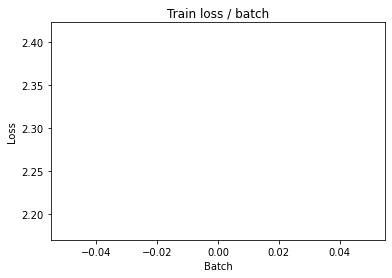

[TRAIN Batch 200/469]	Time 0.013s (0.021s)	Loss 0.3509 (1.0893)	Prec@1  94.5 ( 68.7)	Prec@5  98.4 ( 92.9)


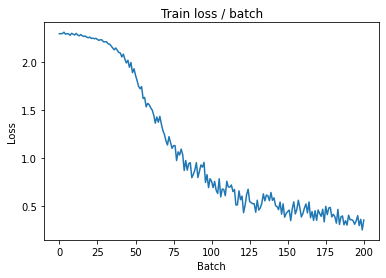

[TRAIN Batch 400/469]	Time 0.005s (0.020s)	Loss 0.2499 (0.6691)	Prec@1  93.0 ( 80.9)	Prec@5 100.0 ( 96.3)


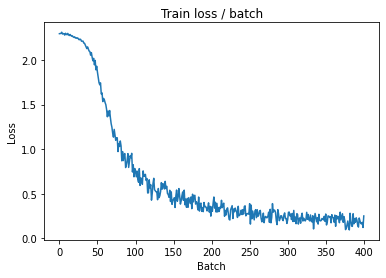


===============> Total time 9s	Avg loss 0.5980	Avg Prec@1 82.86 %	Avg Prec@5 96.81 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 0.0851 (0.0851)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.1465	Avg Prec@1 95.75 %	Avg Prec@5 99.96 %



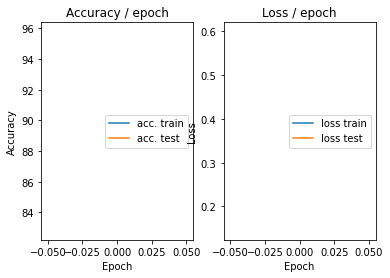

=== EPOCH 2 =====

[TRAIN Batch 000/469]	Time 0.150s (0.150s)	Loss 0.1547 (0.1547)	Prec@1  96.9 ( 96.9)	Prec@5  99.2 ( 99.2)


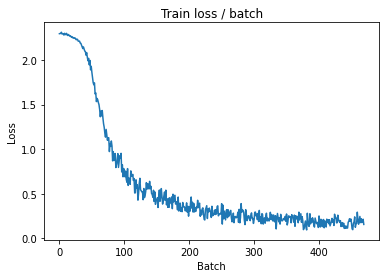

[TRAIN Batch 200/469]	Time 0.005s (0.019s)	Loss 0.1445 (0.1343)	Prec@1  95.3 ( 96.1)	Prec@5 100.0 ( 99.9)


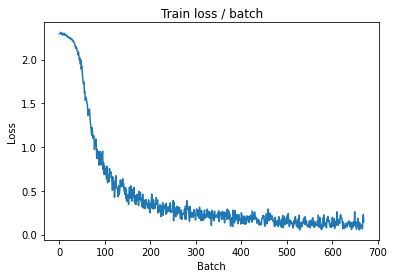

[TRAIN Batch 400/469]	Time 0.028s (0.019s)	Loss 0.0960 (0.1220)	Prec@1  97.7 ( 96.4)	Prec@5 100.0 ( 99.9)


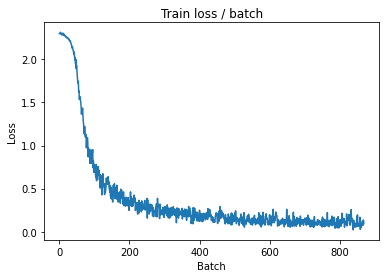


===============> Total time 9s	Avg loss 0.1195	Avg Prec@1 96.47 %	Avg Prec@5 99.91 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 0.0524 (0.0524)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0810	Avg Prec@1 97.47 %	Avg Prec@5 99.99 %



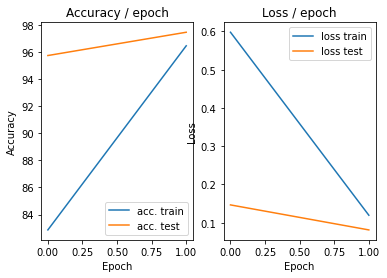

=== EPOCH 3 =====

[TRAIN Batch 000/469]	Time 0.129s (0.129s)	Loss 0.1102 (0.1102)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


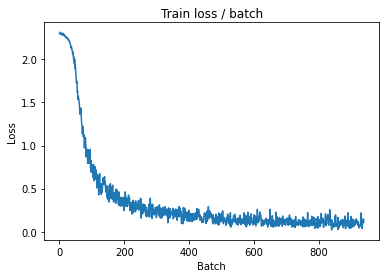

[TRAIN Batch 200/469]	Time 0.034s (0.019s)	Loss 0.1871 (0.0900)	Prec@1  94.5 ( 97.5)	Prec@5  99.2 ( 99.9)


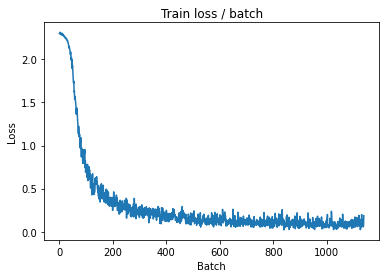

[TRAIN Batch 400/469]	Time 0.005s (0.019s)	Loss 0.0891 (0.0831)	Prec@1  96.1 ( 97.6)	Prec@5 100.0 ( 99.9)


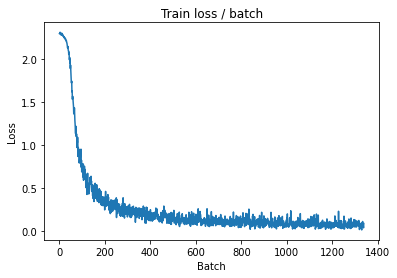


===============> Total time 9s	Avg loss 0.0806	Avg Prec@1 97.61 %	Avg Prec@5 99.95 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 0.0283 (0.0283)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0644	Avg Prec@1 98.02 %	Avg Prec@5 100.00 %



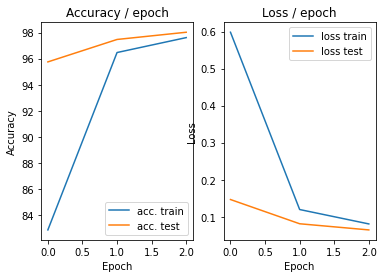

=== EPOCH 4 =====

[TRAIN Batch 000/469]	Time 0.151s (0.151s)	Loss 0.0446 (0.0446)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


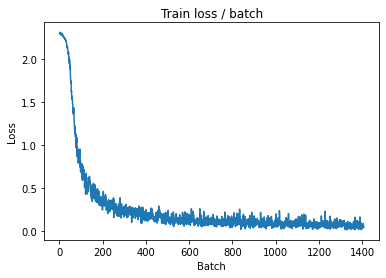

[TRAIN Batch 200/469]	Time 0.028s (0.020s)	Loss 0.0466 (0.0642)	Prec@1  99.2 ( 98.2)	Prec@5 100.0 (100.0)


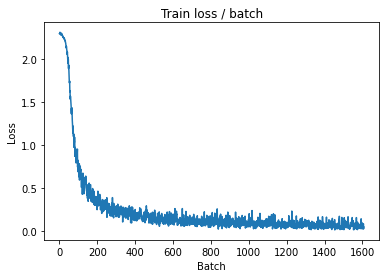

[TRAIN Batch 400/469]	Time 0.026s (0.021s)	Loss 0.0273 (0.0645)	Prec@1  99.2 ( 98.1)	Prec@5 100.0 (100.0)


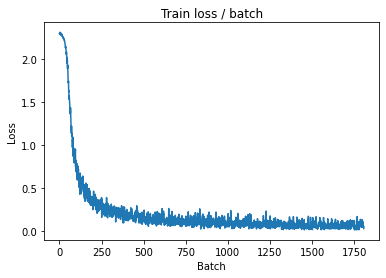


===============> Total time 9s	Avg loss 0.0635	Avg Prec@1 98.10 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.115s (0.115s)	Loss 0.0271 (0.0271)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0541	Avg Prec@1 98.11 %	Avg Prec@5 100.00 %



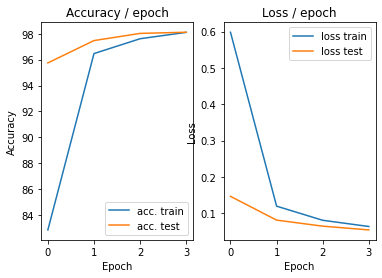

=== EPOCH 5 =====

[TRAIN Batch 000/469]	Time 0.142s (0.142s)	Loss 0.0287 (0.0287)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


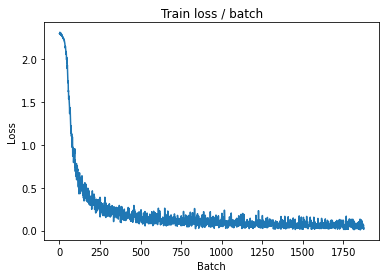

[TRAIN Batch 200/469]	Time 0.035s (0.020s)	Loss 0.0662 (0.0571)	Prec@1  99.2 ( 98.3)	Prec@5 100.0 (100.0)


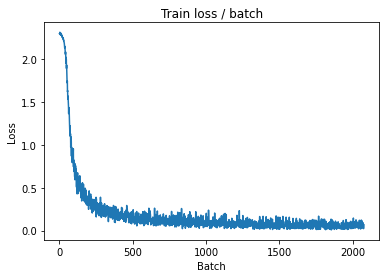

[TRAIN Batch 400/469]	Time 0.005s (0.020s)	Loss 0.0528 (0.0543)	Prec@1  97.7 ( 98.4)	Prec@5 100.0 (100.0)


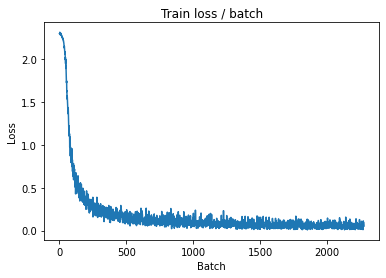


===============> Total time 9s	Avg loss 0.0538	Avg Prec@1 98.41 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.124s (0.124s)	Loss 0.0336 (0.0336)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0470	Avg Prec@1 98.46 %	Avg Prec@5 99.99 %



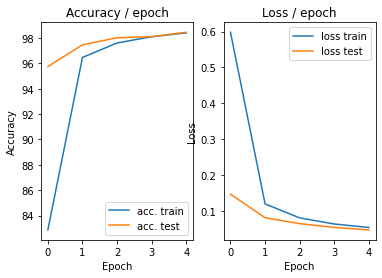

In [ ]:
main(128, 0.1, cuda=True)

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


In [ ]:
main(500, 0.01, epochs= 50,cuda=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201])
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201])
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/100]	Time 0.330s (0.330s)	Loss 2.3043 (2.3043)	Prec@1   8.4 (  8.4)	Prec@5  48.6 ( 48.6)


<Figure size 432x288 with 0 Axes>

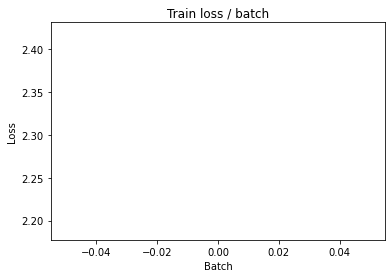


===============> Total time 11s	Avg loss 2.1287	Avg Prec@1 21.84 %	Avg Prec@5 71.19 %

[EVAL Batch 000/020]	Time 0.324s (0.324s)	Loss 1.8943 (1.8943)	Prec@1  33.4 ( 33.4)	Prec@5  83.0 ( 83.0)

===============> Total time 2s	Avg loss 1.9046	Avg Prec@1 31.87 %	Avg Prec@5 82.22 %



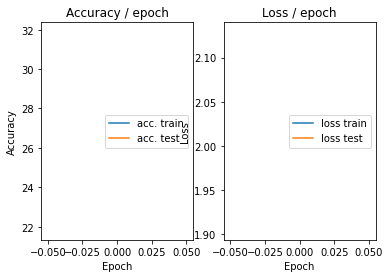

=== EPOCH 2 =====

[TRAIN Batch 000/100]	Time 0.345s (0.345s)	Loss 1.9585 (1.9585)	Prec@1  31.6 ( 31.6)	Prec@5  78.0 ( 78.0)


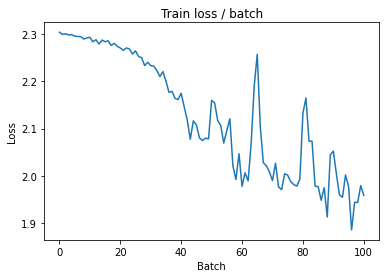


===============> Total time 12s	Avg loss 1.8197	Avg Prec@1 34.54 %	Avg Prec@5 84.40 %

[EVAL Batch 000/020]	Time 0.376s (0.376s)	Loss 1.6698 (1.6698)	Prec@1  40.0 ( 40.0)	Prec@5  88.4 ( 88.4)

===============> Total time 2s	Avg loss 1.6409	Avg Prec@1 41.08 %	Avg Prec@5 89.20 %



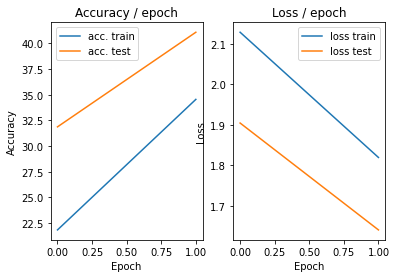

=== EPOCH 3 =====

[TRAIN Batch 000/100]	Time 0.343s (0.343s)	Loss 1.6713 (1.6713)	Prec@1  40.6 ( 40.6)	Prec@5  88.8 ( 88.8)


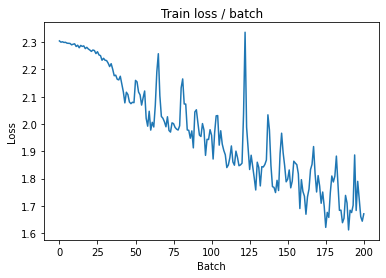


===============> Total time 12s	Avg loss 1.6245	Avg Prec@1 41.65 %	Avg Prec@5 89.27 %

[EVAL Batch 000/020]	Time 0.342s (0.342s)	Loss 1.5804 (1.5804)	Prec@1  39.8 ( 39.8)	Prec@5  92.0 ( 92.0)

===============> Total time 2s	Avg loss 1.5460	Avg Prec@1 42.61 %	Avg Prec@5 91.79 %



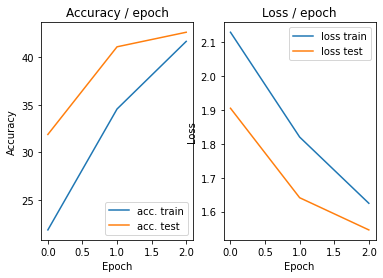

=== EPOCH 4 =====

[TRAIN Batch 000/100]	Time 0.377s (0.377s)	Loss 1.5933 (1.5933)	Prec@1  41.8 ( 41.8)	Prec@5  89.2 ( 89.2)


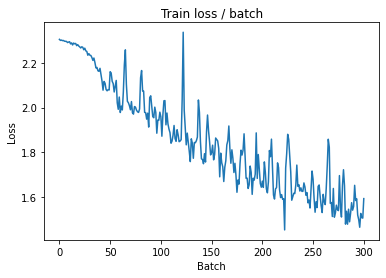


===============> Total time 12s	Avg loss 1.5070	Avg Prec@1 45.88 %	Avg Prec@5 91.32 %

[EVAL Batch 000/020]	Time 0.338s (0.338s)	Loss 1.4284 (1.4284)	Prec@1  49.0 ( 49.0)	Prec@5  92.0 ( 92.0)

===============> Total time 2s	Avg loss 1.4157	Avg Prec@1 48.51 %	Avg Prec@5 92.39 %



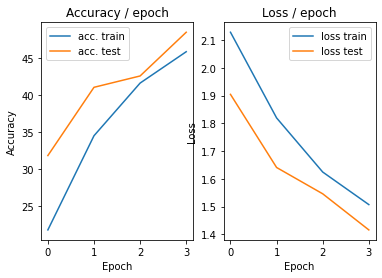

=== EPOCH 5 =====

[TRAIN Batch 000/100]	Time 0.411s (0.411s)	Loss 1.3622 (1.3622)	Prec@1  50.4 ( 50.4)	Prec@5  93.6 ( 93.6)


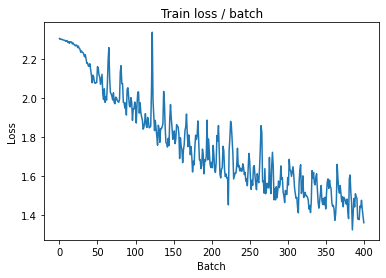


===============> Total time 12s	Avg loss 1.4018	Avg Prec@1 49.85 %	Avg Prec@5 92.95 %

[EVAL Batch 000/020]	Time 0.336s (0.336s)	Loss 1.4393 (1.4393)	Prec@1  48.2 ( 48.2)	Prec@5  92.8 ( 92.8)

===============> Total time 2s	Avg loss 1.4155	Avg Prec@1 48.78 %	Avg Prec@5 92.77 %



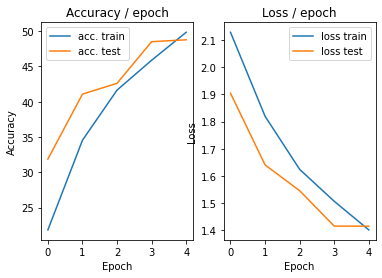

=== EPOCH 6 =====

[TRAIN Batch 000/100]	Time 0.342s (0.342s)	Loss 1.3898 (1.3898)	Prec@1  47.6 ( 47.6)	Prec@5  93.2 ( 93.2)


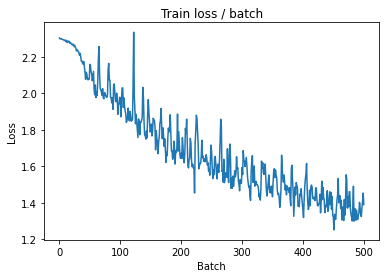


===============> Total time 12s	Avg loss 1.3175	Avg Prec@1 53.32 %	Avg Prec@5 94.00 %

[EVAL Batch 000/020]	Time 0.370s (0.370s)	Loss 1.3135 (1.3135)	Prec@1  51.4 ( 51.4)	Prec@5  96.0 ( 96.0)

===============> Total time 2s	Avg loss 1.2946	Avg Prec@1 52.21 %	Avg Prec@5 94.46 %



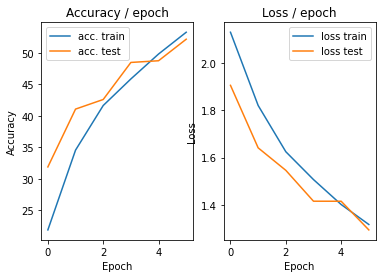

=== EPOCH 7 =====

[TRAIN Batch 000/100]	Time 0.606s (0.606s)	Loss 1.2628 (1.2628)	Prec@1  53.4 ( 53.4)	Prec@5  95.4 ( 95.4)


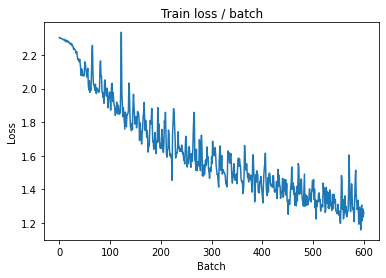


===============> Total time 12s	Avg loss 1.2580	Avg Prec@1 55.38 %	Avg Prec@5 94.57 %

[EVAL Batch 000/020]	Time 0.359s (0.359s)	Loss 1.1744 (1.1744)	Prec@1  57.4 ( 57.4)	Prec@5  96.6 ( 96.6)

===============> Total time 2s	Avg loss 1.1988	Avg Prec@1 57.43 %	Avg Prec@5 95.38 %



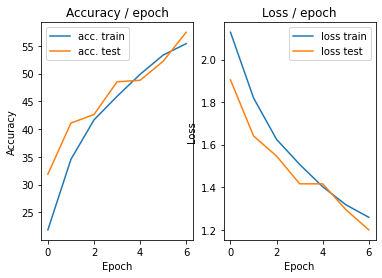

=== EPOCH 8 =====

[TRAIN Batch 000/100]	Time 0.364s (0.364s)	Loss 1.1995 (1.1995)	Prec@1  57.0 ( 57.0)	Prec@5  95.4 ( 95.4)


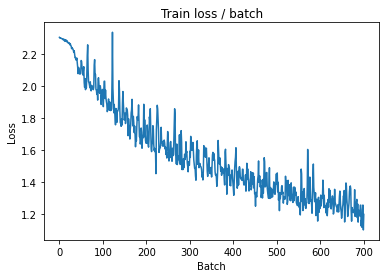


===============> Total time 12s	Avg loss 1.1906	Avg Prec@1 57.94 %	Avg Prec@5 95.45 %

[EVAL Batch 000/020]	Time 0.345s (0.345s)	Loss 1.1717 (1.1717)	Prec@1  59.0 ( 59.0)	Prec@5  95.4 ( 95.4)

===============> Total time 2s	Avg loss 1.1955	Avg Prec@1 57.34 %	Avg Prec@5 95.25 %



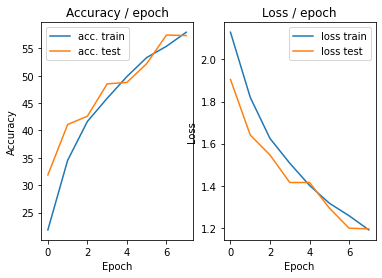

=== EPOCH 9 =====

[TRAIN Batch 000/100]	Time 0.359s (0.359s)	Loss 1.1487 (1.1487)	Prec@1  59.8 ( 59.8)	Prec@5  94.6 ( 94.6)


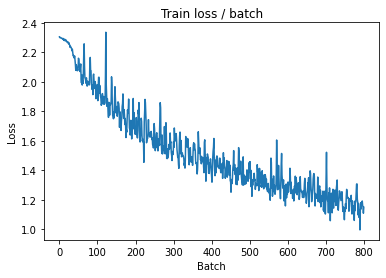


===============> Total time 12s	Avg loss 1.1297	Avg Prec@1 60.20 %	Avg Prec@5 95.86 %

[EVAL Batch 000/020]	Time 0.318s (0.318s)	Loss 1.1558 (1.1558)	Prec@1  59.4 ( 59.4)	Prec@5  95.8 ( 95.8)

===============> Total time 2s	Avg loss 1.1701	Avg Prec@1 58.80 %	Avg Prec@5 94.91 %



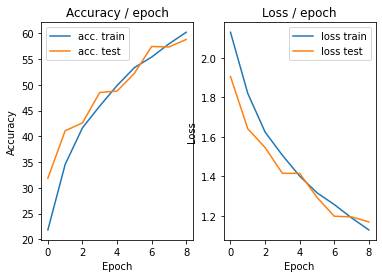

=== EPOCH 10 =====

[TRAIN Batch 000/100]	Time 0.369s (0.369s)	Loss 1.1373 (1.1373)	Prec@1  58.8 ( 58.8)	Prec@5  96.8 ( 96.8)


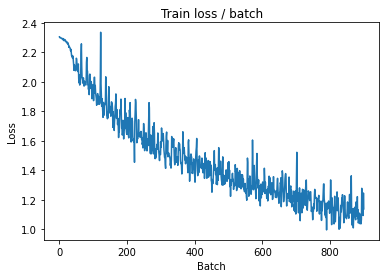


===============> Total time 12s	Avg loss 1.0850	Avg Prec@1 61.62 %	Avg Prec@5 96.17 %

[EVAL Batch 000/020]	Time 0.334s (0.334s)	Loss 1.0622 (1.0622)	Prec@1  63.2 ( 63.2)	Prec@5  97.0 ( 97.0)

===============> Total time 2s	Avg loss 1.0722	Avg Prec@1 62.53 %	Avg Prec@5 96.18 %



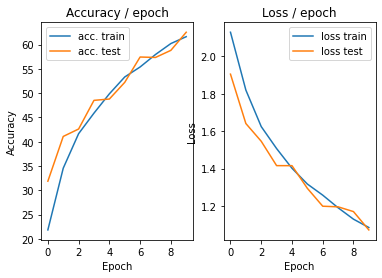

=== EPOCH 11 =====

[TRAIN Batch 000/100]	Time 0.351s (0.351s)	Loss 0.9276 (0.9276)	Prec@1  66.4 ( 66.4)	Prec@5  97.8 ( 97.8)


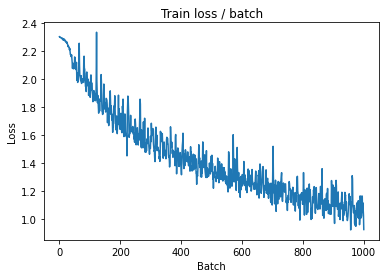


===============> Total time 12s	Avg loss 1.0406	Avg Prec@1 63.60 %	Avg Prec@5 96.49 %

[EVAL Batch 000/020]	Time 0.354s (0.354s)	Loss 1.0291 (1.0291)	Prec@1  65.0 ( 65.0)	Prec@5  97.6 ( 97.6)

===============> Total time 2s	Avg loss 1.0299	Avg Prec@1 63.67 %	Avg Prec@5 96.61 %



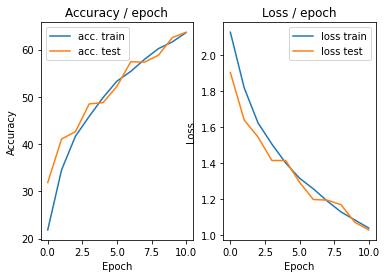

=== EPOCH 12 =====

[TRAIN Batch 000/100]	Time 0.370s (0.370s)	Loss 0.9818 (0.9818)	Prec@1  65.6 ( 65.6)	Prec@5  97.4 ( 97.4)


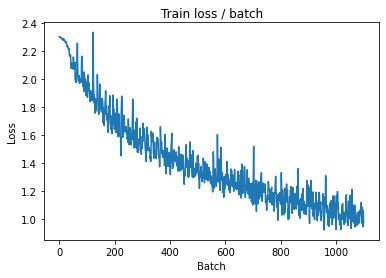


===============> Total time 12s	Avg loss 0.9906	Avg Prec@1 65.30 %	Avg Prec@5 96.84 %

[EVAL Batch 000/020]	Time 0.341s (0.341s)	Loss 1.0303 (1.0303)	Prec@1  63.0 ( 63.0)	Prec@5  97.2 ( 97.2)

===============> Total time 2s	Avg loss 1.0383	Avg Prec@1 63.82 %	Avg Prec@5 96.67 %



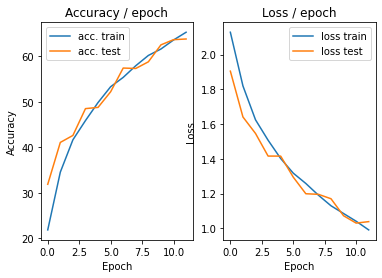

=== EPOCH 13 =====

[TRAIN Batch 000/100]	Time 0.608s (0.608s)	Loss 0.8588 (0.8588)	Prec@1  73.4 ( 73.4)	Prec@5  98.6 ( 98.6)


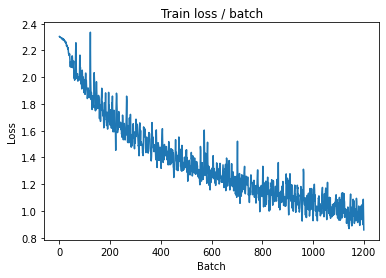


===============> Total time 12s	Avg loss 0.9532	Avg Prec@1 66.70 %	Avg Prec@5 97.13 %

[EVAL Batch 000/020]	Time 0.400s (0.400s)	Loss 1.1332 (1.1332)	Prec@1  60.8 ( 60.8)	Prec@5  95.8 ( 95.8)

===============> Total time 2s	Avg loss 1.0910	Avg Prec@1 62.10 %	Avg Prec@5 96.06 %



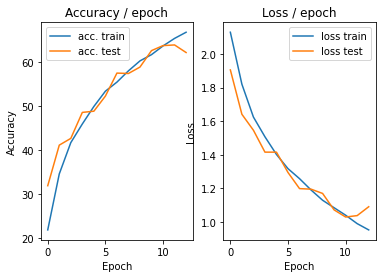

=== EPOCH 14 =====

[TRAIN Batch 000/100]	Time 0.376s (0.376s)	Loss 0.9951 (0.9951)	Prec@1  67.0 ( 67.0)	Prec@5  96.4 ( 96.4)


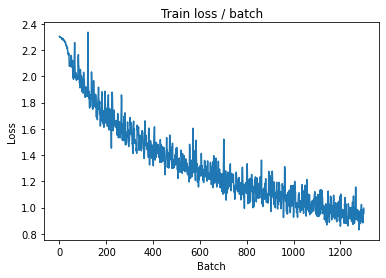


===============> Total time 12s	Avg loss 0.9080	Avg Prec@1 68.17 %	Avg Prec@5 97.40 %

[EVAL Batch 000/020]	Time 0.340s (0.340s)	Loss 0.9261 (0.9261)	Prec@1  65.0 ( 65.0)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.9586	Avg Prec@1 66.74 %	Avg Prec@5 97.14 %



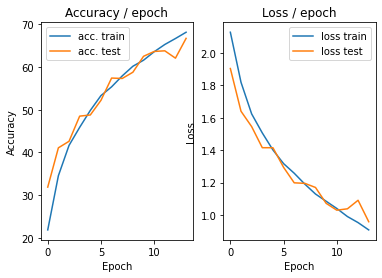

=== EPOCH 15 =====

[TRAIN Batch 000/100]	Time 0.379s (0.379s)	Loss 0.9318 (0.9318)	Prec@1  66.8 ( 66.8)	Prec@5  96.8 ( 96.8)


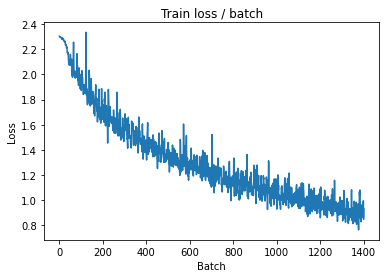


===============> Total time 12s	Avg loss 0.8664	Avg Prec@1 69.73 %	Avg Prec@5 97.64 %

[EVAL Batch 000/020]	Time 0.332s (0.332s)	Loss 0.9670 (0.9670)	Prec@1  64.8 ( 64.8)	Prec@5  97.6 ( 97.6)

===============> Total time 2s	Avg loss 0.9774	Avg Prec@1 66.57 %	Avg Prec@5 96.75 %



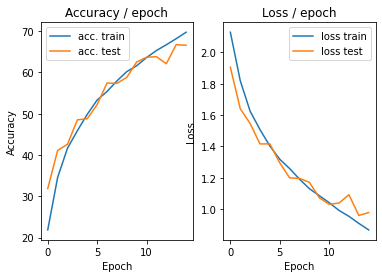

=== EPOCH 16 =====

[TRAIN Batch 000/100]	Time 0.399s (0.399s)	Loss 0.8216 (0.8216)	Prec@1  72.6 ( 72.6)	Prec@5  98.0 ( 98.0)


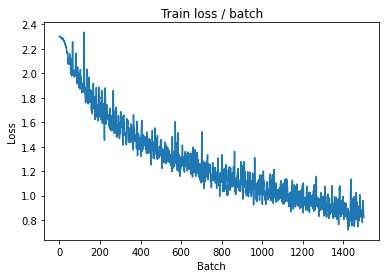


===============> Total time 12s	Avg loss 0.8329	Avg Prec@1 70.95 %	Avg Prec@5 97.82 %

[EVAL Batch 000/020]	Time 0.377s (0.377s)	Loss 0.9533 (0.9533)	Prec@1  66.0 ( 66.0)	Prec@5  97.8 ( 97.8)

===============> Total time 2s	Avg loss 0.9469	Avg Prec@1 66.95 %	Avg Prec@5 97.31 %



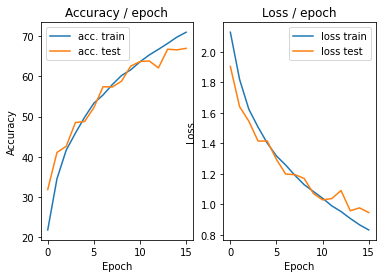

=== EPOCH 17 =====

[TRAIN Batch 000/100]	Time 0.397s (0.397s)	Loss 0.7528 (0.7528)	Prec@1  73.6 ( 73.6)	Prec@5  98.6 ( 98.6)


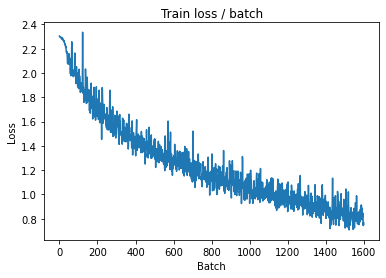


===============> Total time 12s	Avg loss 0.7886	Avg Prec@1 72.47 %	Avg Prec@5 98.10 %

[EVAL Batch 000/020]	Time 0.347s (0.347s)	Loss 1.2189 (1.2189)	Prec@1  59.4 ( 59.4)	Prec@5  93.6 ( 93.6)

===============> Total time 2s	Avg loss 1.2018	Avg Prec@1 61.69 %	Avg Prec@5 94.16 %



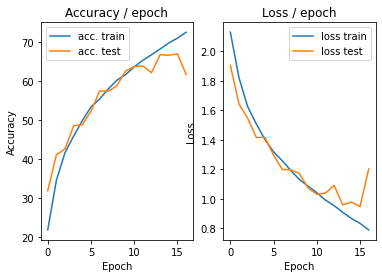

=== EPOCH 18 =====

[TRAIN Batch 000/100]	Time 0.353s (0.353s)	Loss 1.1056 (1.1056)	Prec@1  65.8 ( 65.8)	Prec@5  93.4 ( 93.4)


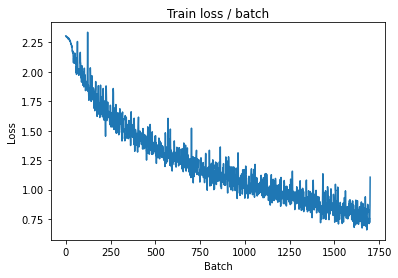


===============> Total time 12s	Avg loss 0.7660	Avg Prec@1 73.35 %	Avg Prec@5 98.21 %

[EVAL Batch 000/020]	Time 0.362s (0.362s)	Loss 0.8611 (0.8611)	Prec@1  68.2 ( 68.2)	Prec@5  98.0 ( 98.0)

===============> Total time 2s	Avg loss 0.8940	Avg Prec@1 68.47 %	Avg Prec@5 97.56 %



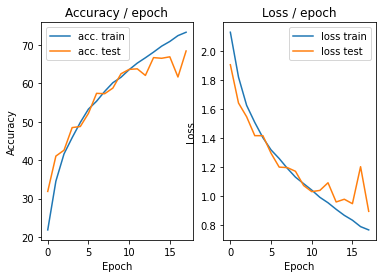

=== EPOCH 19 =====

[TRAIN Batch 000/100]	Time 0.606s (0.606s)	Loss 0.7267 (0.7267)	Prec@1  73.4 ( 73.4)	Prec@5  99.4 ( 99.4)


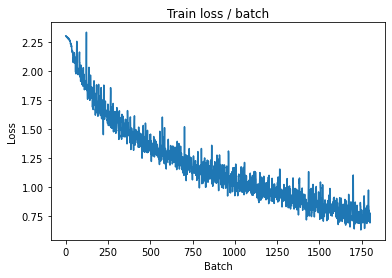


===============> Total time 12s	Avg loss 0.7208	Avg Prec@1 74.87 %	Avg Prec@5 98.45 %

[EVAL Batch 000/020]	Time 0.393s (0.393s)	Loss 0.9010 (0.9010)	Prec@1  68.4 ( 68.4)	Prec@5  98.6 ( 98.6)

===============> Total time 2s	Avg loss 0.9101	Avg Prec@1 68.30 %	Avg Prec@5 97.48 %



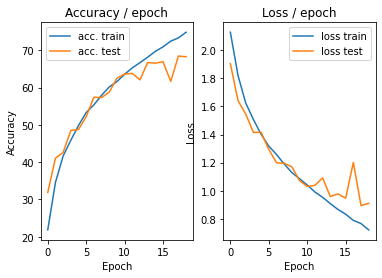

=== EPOCH 20 =====

[TRAIN Batch 000/100]	Time 0.364s (0.364s)	Loss 0.7114 (0.7114)	Prec@1  76.6 ( 76.6)	Prec@5  98.8 ( 98.8)


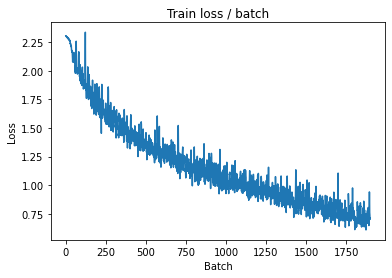


===============> Total time 12s	Avg loss 0.6859	Avg Prec@1 76.37 %	Avg Prec@5 98.66 %

[EVAL Batch 000/020]	Time 0.358s (0.358s)	Loss 0.8548 (0.8548)	Prec@1  70.2 ( 70.2)	Prec@5  97.8 ( 97.8)

===============> Total time 2s	Avg loss 0.8693	Avg Prec@1 70.24 %	Avg Prec@5 97.33 %



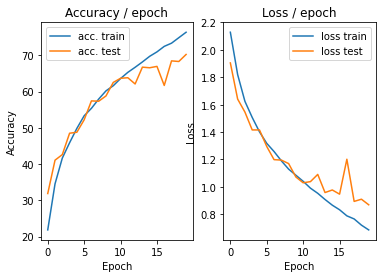

=== EPOCH 21 =====

[TRAIN Batch 000/100]	Time 0.441s (0.441s)	Loss 0.6369 (0.6369)	Prec@1  76.6 ( 76.6)	Prec@5  99.4 ( 99.4)


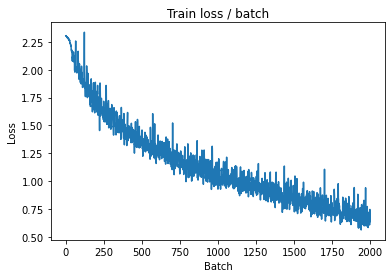


===============> Total time 12s	Avg loss 0.6657	Avg Prec@1 76.75 %	Avg Prec@5 98.64 %

[EVAL Batch 000/020]	Time 0.332s (0.332s)	Loss 0.8336 (0.8336)	Prec@1  70.4 ( 70.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8496	Avg Prec@1 70.87 %	Avg Prec@5 97.62 %



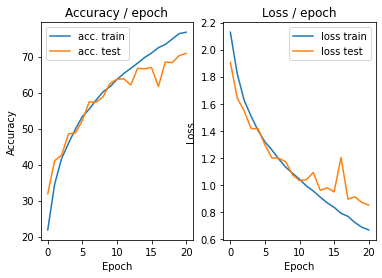

=== EPOCH 22 =====

[TRAIN Batch 000/100]	Time 0.398s (0.398s)	Loss 0.6295 (0.6295)	Prec@1  79.0 ( 79.0)	Prec@5  99.0 ( 99.0)


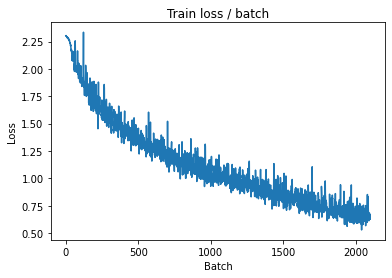


===============> Total time 12s	Avg loss 0.6236	Avg Prec@1 78.34 %	Avg Prec@5 98.86 %

[EVAL Batch 000/020]	Time 0.393s (0.393s)	Loss 0.8607 (0.8607)	Prec@1  69.2 ( 69.2)	Prec@5  98.2 ( 98.2)

===============> Total time 2s	Avg loss 0.8629	Avg Prec@1 70.59 %	Avg Prec@5 97.40 %



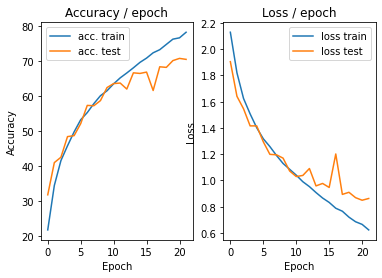

=== EPOCH 23 =====

[TRAIN Batch 000/100]	Time 0.383s (0.383s)	Loss 0.5826 (0.5826)	Prec@1  79.8 ( 79.8)	Prec@5  99.4 ( 99.4)


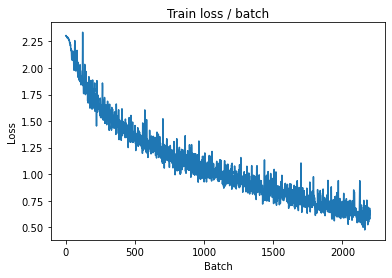


===============> Total time 12s	Avg loss 0.5919	Avg Prec@1 79.32 %	Avg Prec@5 99.02 %

[EVAL Batch 000/020]	Time 0.362s (0.362s)	Loss 0.8611 (0.8611)	Prec@1  69.0 ( 69.0)	Prec@5  98.2 ( 98.2)

===============> Total time 2s	Avg loss 0.8745	Avg Prec@1 70.13 %	Avg Prec@5 97.65 %



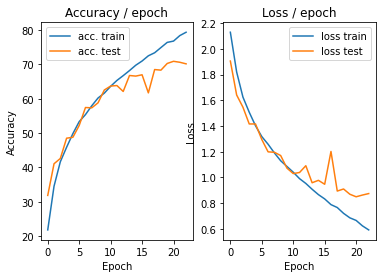

=== EPOCH 24 =====

[TRAIN Batch 000/100]	Time 0.377s (0.377s)	Loss 0.5210 (0.5210)	Prec@1  81.4 ( 81.4)	Prec@5 100.0 (100.0)


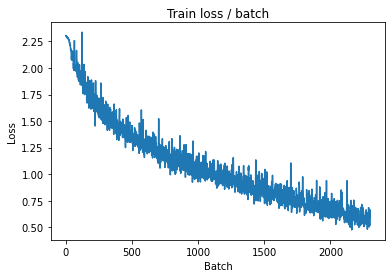


===============> Total time 12s	Avg loss 0.5670	Avg Prec@1 80.33 %	Avg Prec@5 99.13 %

[EVAL Batch 000/020]	Time 0.364s (0.364s)	Loss 0.8603 (0.8603)	Prec@1  70.0 ( 70.0)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.8961	Avg Prec@1 70.24 %	Avg Prec@5 97.72 %



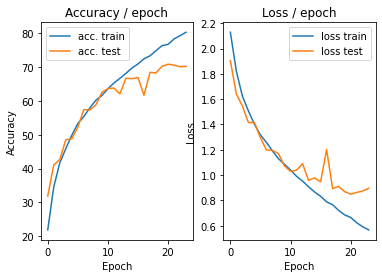

=== EPOCH 25 =====

[TRAIN Batch 000/100]	Time 0.619s (0.619s)	Loss 0.4967 (0.4967)	Prec@1  83.8 ( 83.8)	Prec@5  99.0 ( 99.0)


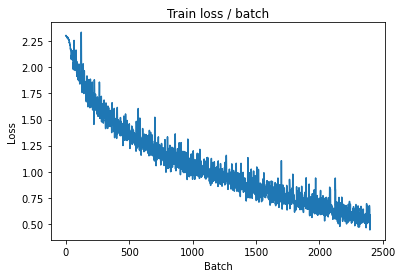


===============> Total time 12s	Avg loss 0.5335	Avg Prec@1 81.44 %	Avg Prec@5 99.24 %

[EVAL Batch 000/020]	Time 0.343s (0.343s)	Loss 0.8166 (0.8166)	Prec@1  71.0 ( 71.0)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.8604	Avg Prec@1 70.93 %	Avg Prec@5 97.67 %



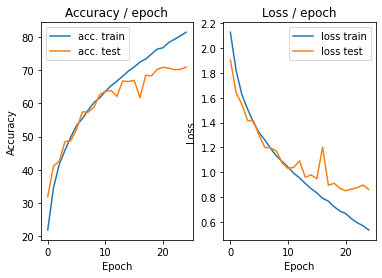

=== EPOCH 26 =====

[TRAIN Batch 000/100]	Time 0.391s (0.391s)	Loss 0.5098 (0.5098)	Prec@1  81.0 ( 81.0)	Prec@5  99.4 ( 99.4)


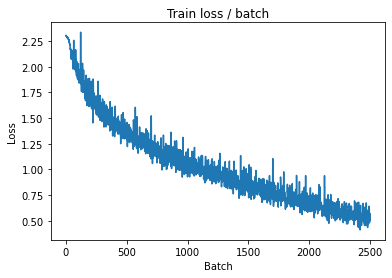


===============> Total time 12s	Avg loss 0.5057	Avg Prec@1 82.51 %	Avg Prec@5 99.34 %

[EVAL Batch 000/020]	Time 0.379s (0.379s)	Loss 0.8674 (0.8674)	Prec@1  70.4 ( 70.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.9099	Avg Prec@1 70.09 %	Avg Prec@5 97.72 %



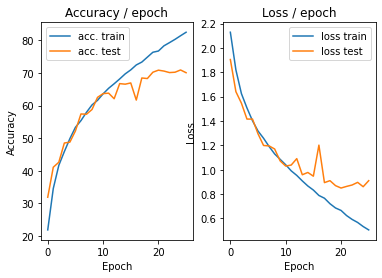

=== EPOCH 27 =====

[TRAIN Batch 000/100]	Time 0.398s (0.398s)	Loss 0.5389 (0.5389)	Prec@1  80.6 ( 80.6)	Prec@5  99.6 ( 99.6)


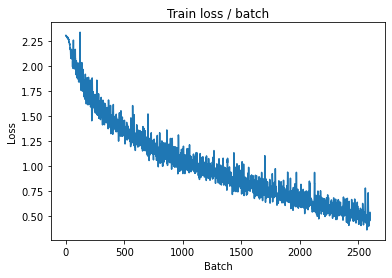


===============> Total time 12s	Avg loss 0.4849	Avg Prec@1 83.43 %	Avg Prec@5 99.40 %

[EVAL Batch 000/020]	Time 0.398s (0.398s)	Loss 0.8064 (0.8064)	Prec@1  73.4 ( 73.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8316	Avg Prec@1 72.34 %	Avg Prec@5 97.75 %



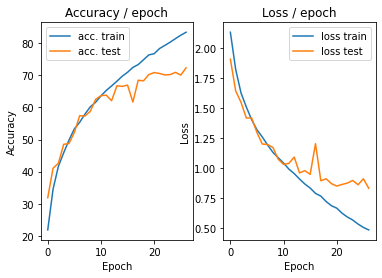

=== EPOCH 28 =====

[TRAIN Batch 000/100]	Time 0.381s (0.381s)	Loss 0.4354 (0.4354)	Prec@1  85.4 ( 85.4)	Prec@5  99.2 ( 99.2)


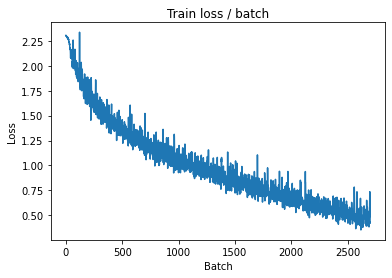


===============> Total time 12s	Avg loss 0.4444	Avg Prec@1 84.93 %	Avg Prec@5 99.50 %

[EVAL Batch 000/020]	Time 0.344s (0.344s)	Loss 0.7900 (0.7900)	Prec@1  72.2 ( 72.2)	Prec@5  98.2 ( 98.2)

===============> Total time 2s	Avg loss 0.8291	Avg Prec@1 72.45 %	Avg Prec@5 97.82 %



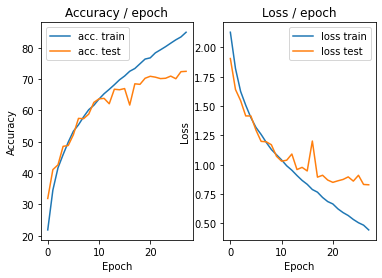

=== EPOCH 29 =====

[TRAIN Batch 000/100]	Time 0.377s (0.377s)	Loss 0.3703 (0.3703)	Prec@1  88.0 ( 88.0)	Prec@5  99.6 ( 99.6)


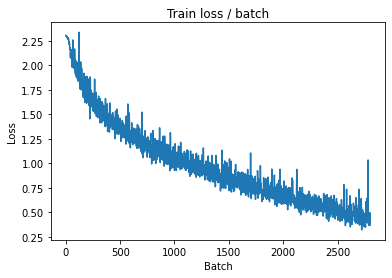


===============> Total time 12s	Avg loss 0.4210	Avg Prec@1 85.48 %	Avg Prec@5 99.55 %

[EVAL Batch 000/020]	Time 0.406s (0.406s)	Loss 0.7795 (0.7795)	Prec@1  72.2 ( 72.2)	Prec@5  98.2 ( 98.2)

===============> Total time 2s	Avg loss 0.8468	Avg Prec@1 72.54 %	Avg Prec@5 97.83 %



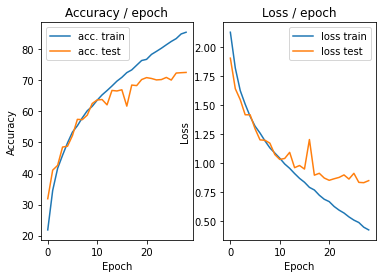

=== EPOCH 30 =====

[TRAIN Batch 000/100]	Time 0.401s (0.401s)	Loss 0.3569 (0.3569)	Prec@1  88.4 ( 88.4)	Prec@5  99.8 ( 99.8)


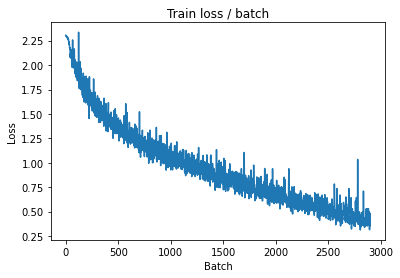


===============> Total time 12s	Avg loss 0.3944	Avg Prec@1 86.64 %	Avg Prec@5 99.58 %

[EVAL Batch 000/020]	Time 0.347s (0.347s)	Loss 0.7896 (0.7896)	Prec@1  73.0 ( 73.0)	Prec@5  98.2 ( 98.2)

===============> Total time 2s	Avg loss 0.8302	Avg Prec@1 72.97 %	Avg Prec@5 98.01 %



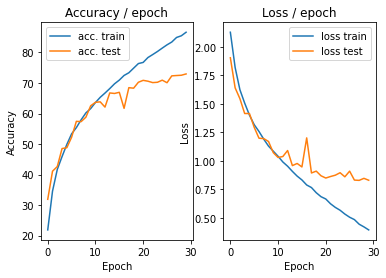

In [ ]:
main(500, 0.05, epochs= 30,cuda=True)

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode =True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(p=0.5)
  
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201]),
            transforms.CenterCrop(28)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/100]	Time 1.411s (1.411s)	Loss 2.3027 (2.3027)	Prec@1  11.2 ( 11.2)	Prec@5  49.2 ( 49.2)


<Figure size 432x288 with 0 Axes>

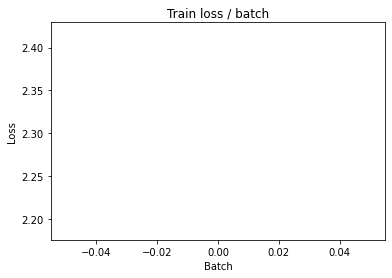


===============> Total time 19s	Avg loss 2.1510	Avg Prec@1 22.26 %	Avg Prec@5 69.70 %

[EVAL Batch 000/020]	Time 0.402s (0.402s)	Loss 1.9267 (1.9267)	Prec@1  30.0 ( 30.0)	Prec@5  83.2 ( 83.2)

===============> Total time 3s	Avg loss 1.9217	Avg Prec@1 30.57 %	Avg Prec@5 80.95 %



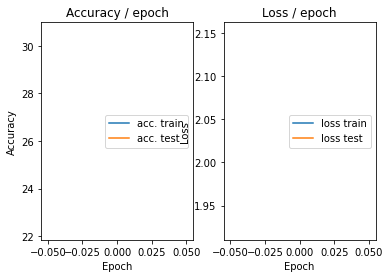

=== EPOCH 2 =====

[TRAIN Batch 000/100]	Time 0.495s (0.495s)	Loss 1.9679 (1.9679)	Prec@1  30.6 ( 30.6)	Prec@5  80.0 ( 80.0)


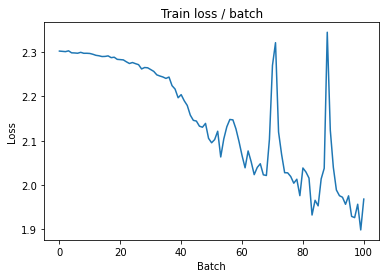


===============> Total time 19s	Avg loss 1.8803	Avg Prec@1 31.70 %	Avg Prec@5 82.98 %

[EVAL Batch 000/020]	Time 0.424s (0.424s)	Loss 1.8322 (1.8322)	Prec@1  33.2 ( 33.2)	Prec@5  84.8 ( 84.8)

===============> Total time 3s	Avg loss 1.7984	Avg Prec@1 34.10 %	Avg Prec@5 86.75 %



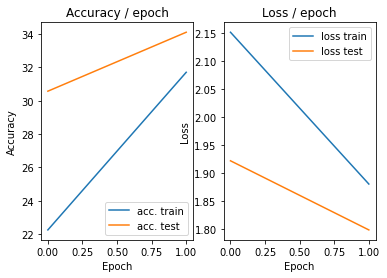

=== EPOCH 3 =====

[TRAIN Batch 000/100]	Time 0.489s (0.489s)	Loss 1.7458 (1.7458)	Prec@1  34.2 ( 34.2)	Prec@5  87.6 ( 87.6)


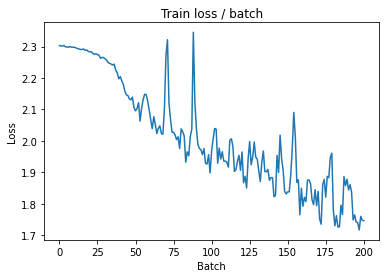


===============> Total time 19s	Avg loss 1.7205	Avg Prec@1 37.79 %	Avg Prec@5 87.26 %

[EVAL Batch 000/020]	Time 0.409s (0.409s)	Loss 1.6355 (1.6355)	Prec@1  39.2 ( 39.2)	Prec@5  87.8 ( 87.8)

===============> Total time 3s	Avg loss 1.5853	Avg Prec@1 41.69 %	Avg Prec@5 90.48 %



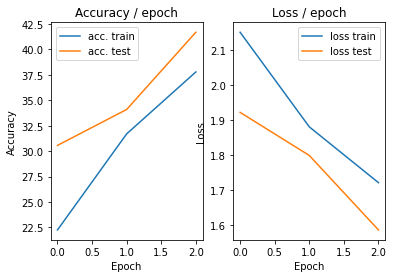

=== EPOCH 4 =====

[TRAIN Batch 000/100]	Time 0.511s (0.511s)	Loss 1.6400 (1.6400)	Prec@1  37.8 ( 37.8)	Prec@5  90.8 ( 90.8)


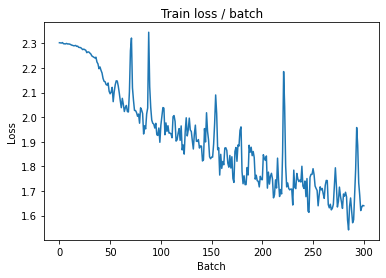


===============> Total time 19s	Avg loss 1.6011	Avg Prec@1 41.90 %	Avg Prec@5 90.15 %

[EVAL Batch 000/020]	Time 0.562s (0.562s)	Loss 1.5320 (1.5320)	Prec@1  43.2 ( 43.2)	Prec@5  89.6 ( 89.6)

===============> Total time 3s	Avg loss 1.4860	Avg Prec@1 47.30 %	Avg Prec@5 92.27 %



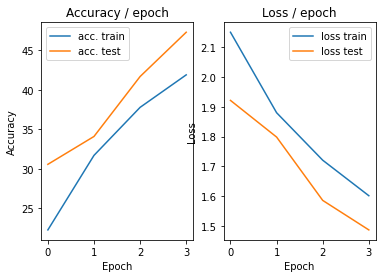

=== EPOCH 5 =====

[TRAIN Batch 000/100]	Time 0.500s (0.500s)	Loss 1.5652 (1.5652)	Prec@1  43.6 ( 43.6)	Prec@5  90.6 ( 90.6)


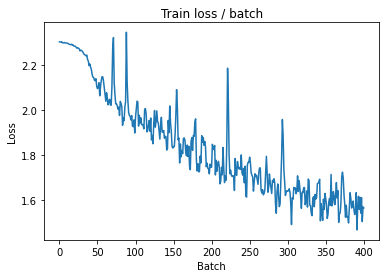


===============> Total time 19s	Avg loss 1.5202	Avg Prec@1 45.11 %	Avg Prec@5 91.38 %

[EVAL Batch 000/020]	Time 0.415s (0.415s)	Loss 1.4311 (1.4311)	Prec@1  48.4 ( 48.4)	Prec@5  93.2 ( 93.2)

===============> Total time 3s	Avg loss 1.4312	Avg Prec@1 49.20 %	Avg Prec@5 92.90 %



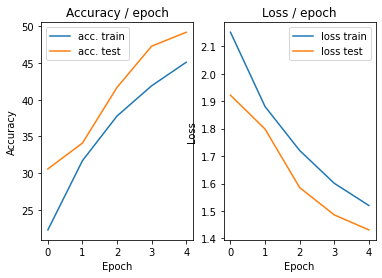

=== EPOCH 6 =====

[TRAIN Batch 000/100]	Time 0.505s (0.505s)	Loss 1.5235 (1.5235)	Prec@1  45.2 ( 45.2)	Prec@5  92.6 ( 92.6)


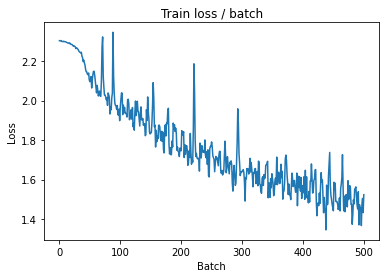


===============> Total time 19s	Avg loss 1.4576	Avg Prec@1 47.64 %	Avg Prec@5 92.29 %

[EVAL Batch 000/020]	Time 0.422s (0.422s)	Loss 1.3800 (1.3800)	Prec@1  50.8 ( 50.8)	Prec@5  92.4 ( 92.4)

===============> Total time 3s	Avg loss 1.3759	Avg Prec@1 51.60 %	Avg Prec@5 93.06 %



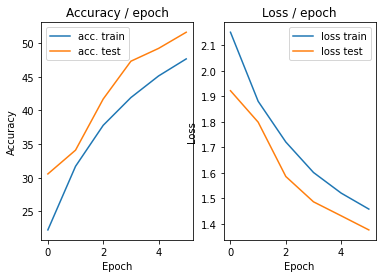

=== EPOCH 7 =====

[TRAIN Batch 000/100]	Time 0.505s (0.505s)	Loss 1.4072 (1.4072)	Prec@1  51.8 ( 51.8)	Prec@5  90.8 ( 90.8)


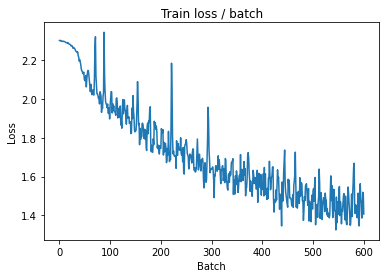


===============> Total time 19s	Avg loss 1.3967	Avg Prec@1 50.07 %	Avg Prec@5 93.01 %

[EVAL Batch 000/020]	Time 0.444s (0.444s)	Loss 1.3096 (1.3096)	Prec@1  56.0 ( 56.0)	Prec@5  94.4 ( 94.4)

===============> Total time 3s	Avg loss 1.2982	Avg Prec@1 54.68 %	Avg Prec@5 94.34 %



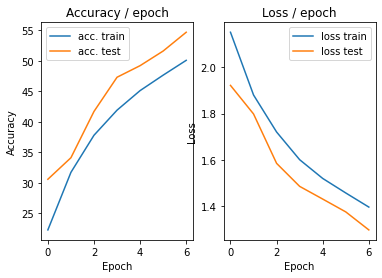

=== EPOCH 8 =====

[TRAIN Batch 000/100]	Time 0.492s (0.492s)	Loss 1.3564 (1.3564)	Prec@1  53.2 ( 53.2)	Prec@5  93.8 ( 93.8)


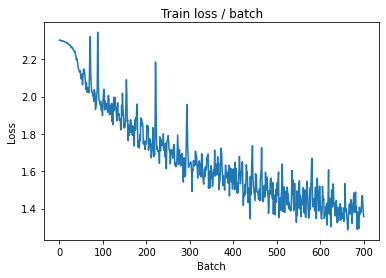


===============> Total time 19s	Avg loss 1.3422	Avg Prec@1 52.22 %	Avg Prec@5 93.70 %

[EVAL Batch 000/020]	Time 0.425s (0.425s)	Loss 1.2523 (1.2523)	Prec@1  57.2 ( 57.2)	Prec@5  95.8 ( 95.8)

===============> Total time 3s	Avg loss 1.2556	Avg Prec@1 55.37 %	Avg Prec@5 94.58 %



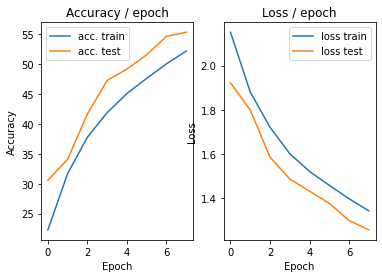

=== EPOCH 9 =====

[TRAIN Batch 000/100]	Time 0.500s (0.500s)	Loss 1.2601 (1.2601)	Prec@1  52.6 ( 52.6)	Prec@5  94.8 ( 94.8)


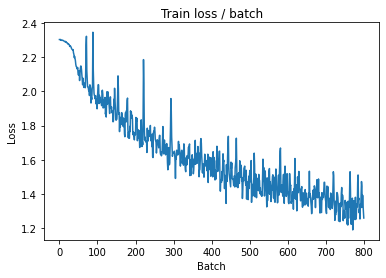


===============> Total time 19s	Avg loss 1.2915	Avg Prec@1 54.00 %	Avg Prec@5 94.27 %

[EVAL Batch 000/020]	Time 0.454s (0.454s)	Loss 1.2301 (1.2301)	Prec@1  56.0 ( 56.0)	Prec@5  96.8 ( 96.8)

===============> Total time 3s	Avg loss 1.2147	Avg Prec@1 56.92 %	Avg Prec@5 95.21 %



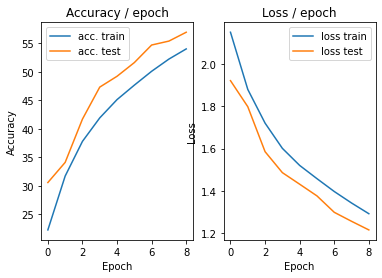

=== EPOCH 10 =====

[TRAIN Batch 000/100]	Time 0.712s (0.712s)	Loss 1.2901 (1.2901)	Prec@1  54.4 ( 54.4)	Prec@5  93.0 ( 93.0)


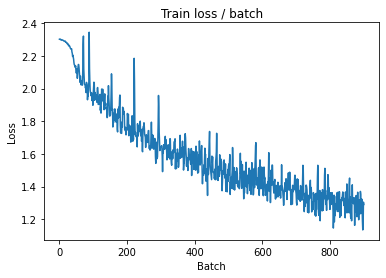


===============> Total time 19s	Avg loss 1.2504	Avg Prec@1 55.96 %	Avg Prec@5 94.56 %

[EVAL Batch 000/020]	Time 0.418s (0.418s)	Loss 1.1702 (1.1702)	Prec@1  60.2 ( 60.2)	Prec@5  97.0 ( 97.0)

===============> Total time 3s	Avg loss 1.1735	Avg Prec@1 58.74 %	Avg Prec@5 95.34 %



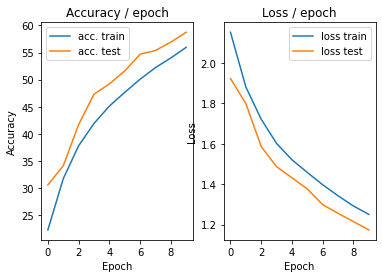

=== EPOCH 11 =====

[TRAIN Batch 000/100]	Time 0.524s (0.524s)	Loss 1.1919 (1.1919)	Prec@1  55.6 ( 55.6)	Prec@5  95.8 ( 95.8)


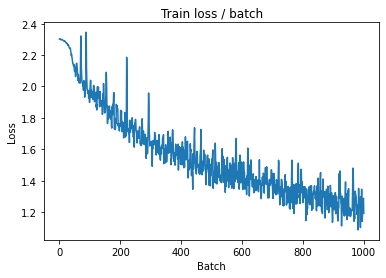


===============> Total time 19s	Avg loss 1.2019	Avg Prec@1 57.60 %	Avg Prec@5 95.08 %

[EVAL Batch 000/020]	Time 0.443s (0.443s)	Loss 1.1117 (1.1117)	Prec@1  60.2 ( 60.2)	Prec@5  97.2 ( 97.2)

===============> Total time 3s	Avg loss 1.1043	Avg Prec@1 61.15 %	Avg Prec@5 95.78 %



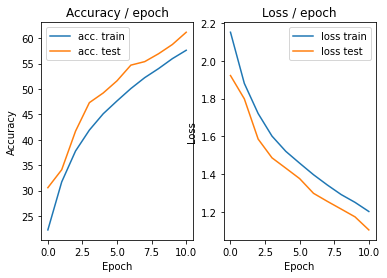

=== EPOCH 12 =====

[TRAIN Batch 000/100]	Time 0.507s (0.507s)	Loss 1.0823 (1.0823)	Prec@1  60.8 ( 60.8)	Prec@5  96.2 ( 96.2)


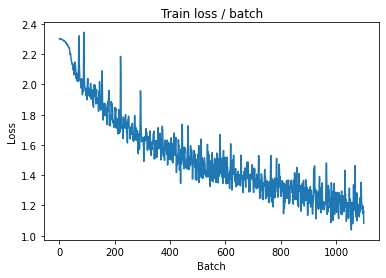


===============> Total time 19s	Avg loss 1.1580	Avg Prec@1 59.09 %	Avg Prec@5 95.44 %

[EVAL Batch 000/020]	Time 0.440s (0.440s)	Loss 1.0641 (1.0641)	Prec@1  62.8 ( 62.8)	Prec@5  97.0 ( 97.0)

===============> Total time 3s	Avg loss 1.0592	Avg Prec@1 63.05 %	Avg Prec@5 96.17 %



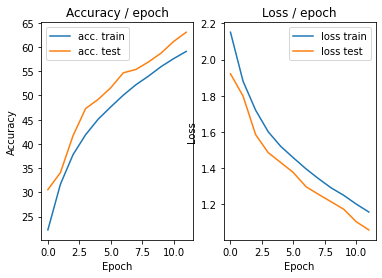

=== EPOCH 13 =====

[TRAIN Batch 000/100]	Time 0.535s (0.535s)	Loss 1.0099 (1.0099)	Prec@1  63.8 ( 63.8)	Prec@5  96.0 ( 96.0)


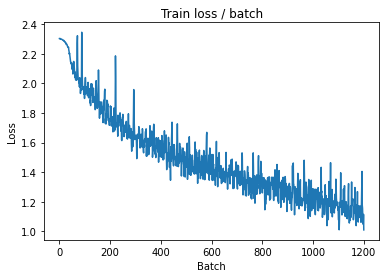


===============> Total time 19s	Avg loss 1.1178	Avg Prec@1 60.74 %	Avg Prec@5 95.75 %

[EVAL Batch 000/020]	Time 0.438s (0.438s)	Loss 1.1084 (1.1084)	Prec@1  60.0 ( 60.0)	Prec@5  97.4 ( 97.4)

===============> Total time 3s	Avg loss 1.0741	Avg Prec@1 62.59 %	Avg Prec@5 96.32 %



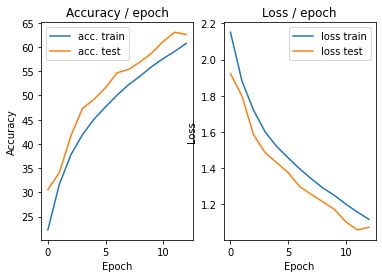

=== EPOCH 14 =====

[TRAIN Batch 000/100]	Time 0.516s (0.516s)	Loss 1.1480 (1.1480)	Prec@1  60.6 ( 60.6)	Prec@5  95.2 ( 95.2)


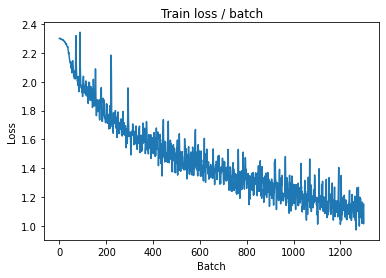


===============> Total time 19s	Avg loss 1.0909	Avg Prec@1 61.73 %	Avg Prec@5 96.10 %

[EVAL Batch 000/020]	Time 0.415s (0.415s)	Loss 1.0108 (1.0108)	Prec@1  63.8 ( 63.8)	Prec@5  97.6 ( 97.6)

===============> Total time 3s	Avg loss 1.0053	Avg Prec@1 65.23 %	Avg Prec@5 96.57 %



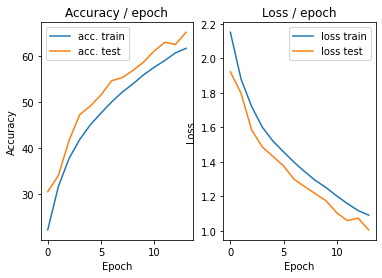

=== EPOCH 15 =====

[TRAIN Batch 000/100]	Time 0.713s (0.713s)	Loss 0.9237 (0.9237)	Prec@1  67.2 ( 67.2)	Prec@5  96.6 ( 96.6)


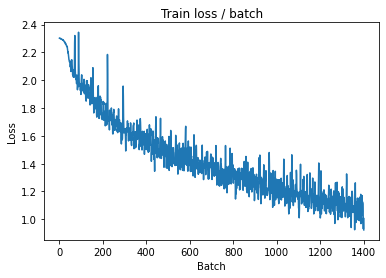


===============> Total time 19s	Avg loss 1.0572	Avg Prec@1 62.79 %	Avg Prec@5 96.21 %

[EVAL Batch 000/020]	Time 0.441s (0.441s)	Loss 0.9951 (0.9951)	Prec@1  66.0 ( 66.0)	Prec@5  97.2 ( 97.2)

===============> Total time 3s	Avg loss 0.9820	Avg Prec@1 65.85 %	Avg Prec@5 97.07 %



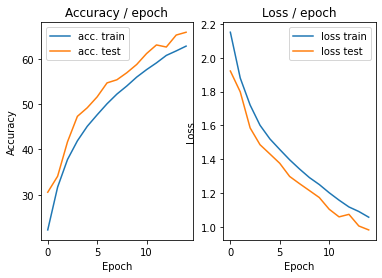

=== EPOCH 16 =====

[TRAIN Batch 000/100]	Time 0.499s (0.499s)	Loss 1.0226 (1.0226)	Prec@1  63.4 ( 63.4)	Prec@5  98.4 ( 98.4)


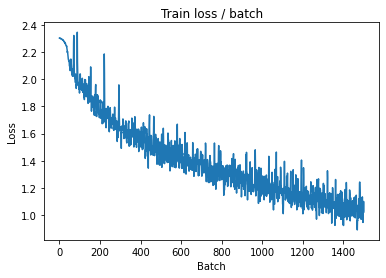


===============> Total time 19s	Avg loss 1.0183	Avg Prec@1 63.95 %	Avg Prec@5 96.60 %

[EVAL Batch 000/020]	Time 0.451s (0.451s)	Loss 1.0794 (1.0794)	Prec@1  62.2 ( 62.2)	Prec@5  97.4 ( 97.4)

===============> Total time 3s	Avg loss 1.0634	Avg Prec@1 62.05 %	Avg Prec@5 96.60 %



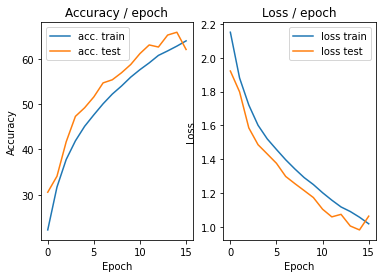

=== EPOCH 17 =====

[TRAIN Batch 000/100]	Time 0.540s (0.540s)	Loss 1.1881 (1.1881)	Prec@1  56.8 ( 56.8)	Prec@5  96.8 ( 96.8)


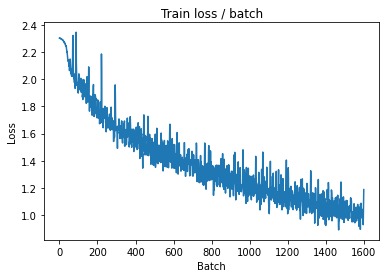


===============> Total time 19s	Avg loss 1.0018	Avg Prec@1 64.82 %	Avg Prec@5 96.74 %

[EVAL Batch 000/020]	Time 0.428s (0.428s)	Loss 0.9523 (0.9523)	Prec@1  67.6 ( 67.6)	Prec@5  97.2 ( 97.2)

===============> Total time 3s	Avg loss 0.9531	Avg Prec@1 66.86 %	Avg Prec@5 96.94 %



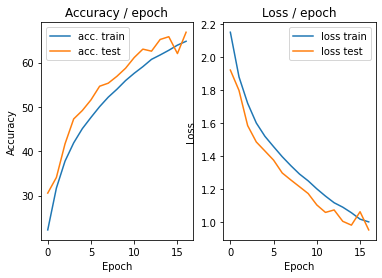

=== EPOCH 18 =====

[TRAIN Batch 000/100]	Time 0.558s (0.558s)	Loss 1.0005 (1.0005)	Prec@1  65.0 ( 65.0)	Prec@5  96.4 ( 96.4)


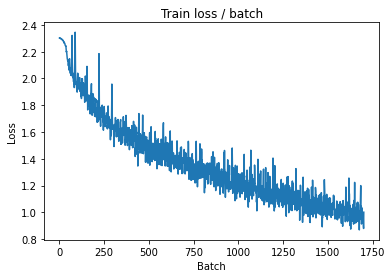


===============> Total time 19s	Avg loss 0.9655	Avg Prec@1 66.27 %	Avg Prec@5 96.82 %

[EVAL Batch 000/020]	Time 0.434s (0.434s)	Loss 0.9428 (0.9428)	Prec@1  67.6 ( 67.6)	Prec@5  97.4 ( 97.4)

===============> Total time 3s	Avg loss 0.9278	Avg Prec@1 67.23 %	Avg Prec@5 97.55 %



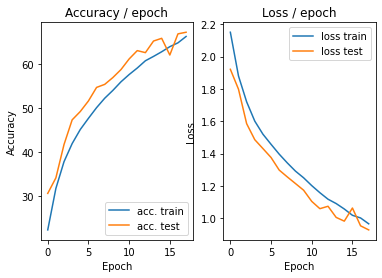

=== EPOCH 19 =====

[TRAIN Batch 000/100]	Time 0.530s (0.530s)	Loss 0.9305 (0.9305)	Prec@1  67.0 ( 67.0)	Prec@5  97.2 ( 97.2)


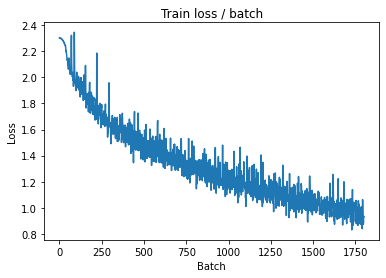


===============> Total time 19s	Avg loss 0.9445	Avg Prec@1 67.01 %	Avg Prec@5 97.05 %

[EVAL Batch 000/020]	Time 0.436s (0.436s)	Loss 0.8774 (0.8774)	Prec@1  69.6 ( 69.6)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.8873	Avg Prec@1 69.36 %	Avg Prec@5 97.43 %



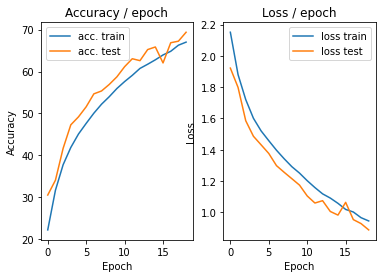

=== EPOCH 20 =====

[TRAIN Batch 000/100]	Time 0.506s (0.506s)	Loss 0.8610 (0.8610)	Prec@1  68.6 ( 68.6)	Prec@5  97.2 ( 97.2)


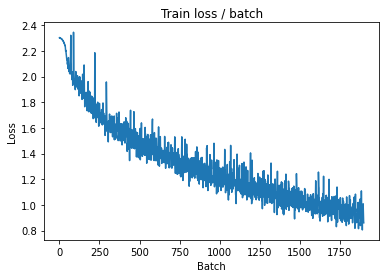


===============> Total time 19s	Avg loss 0.9150	Avg Prec@1 68.10 %	Avg Prec@5 97.28 %

[EVAL Batch 000/020]	Time 0.615s (0.615s)	Loss 0.8754 (0.8754)	Prec@1  69.6 ( 69.6)	Prec@5  98.2 ( 98.2)

===============> Total time 3s	Avg loss 0.8870	Avg Prec@1 68.67 %	Avg Prec@5 97.55 %



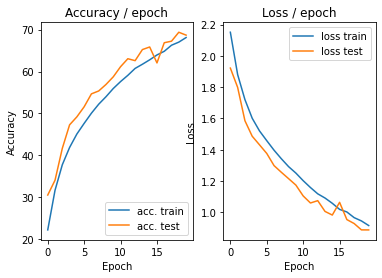

=== EPOCH 21 =====

[TRAIN Batch 000/100]	Time 0.518s (0.518s)	Loss 0.9162 (0.9162)	Prec@1  70.2 ( 70.2)	Prec@5  97.8 ( 97.8)


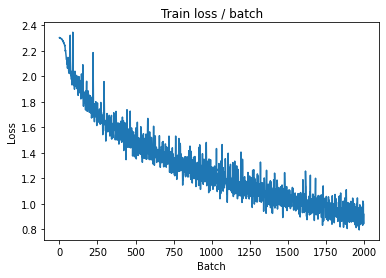


===============> Total time 19s	Avg loss 0.8934	Avg Prec@1 68.83 %	Avg Prec@5 97.46 %

[EVAL Batch 000/020]	Time 0.415s (0.415s)	Loss 0.8542 (0.8542)	Prec@1  71.0 ( 71.0)	Prec@5  98.2 ( 98.2)

===============> Total time 3s	Avg loss 0.8563	Avg Prec@1 70.32 %	Avg Prec@5 97.62 %



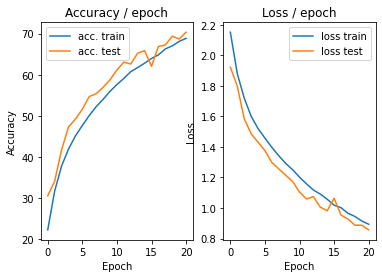

=== EPOCH 22 =====

[TRAIN Batch 000/100]	Time 0.510s (0.510s)	Loss 0.8874 (0.8874)	Prec@1  69.2 ( 69.2)	Prec@5  96.8 ( 96.8)


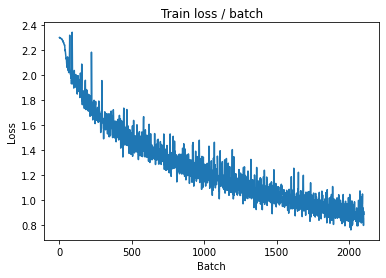


===============> Total time 19s	Avg loss 0.8690	Avg Prec@1 69.76 %	Avg Prec@5 97.45 %

[EVAL Batch 000/020]	Time 0.460s (0.460s)	Loss 0.8561 (0.8561)	Prec@1  67.8 ( 67.8)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.8726	Avg Prec@1 69.75 %	Avg Prec@5 97.37 %



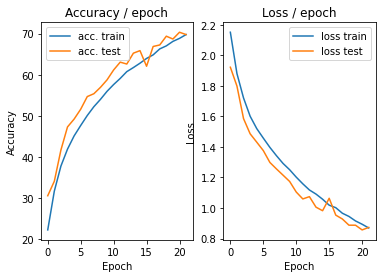

=== EPOCH 23 =====

[TRAIN Batch 000/100]	Time 0.511s (0.511s)	Loss 0.8946 (0.8946)	Prec@1  68.6 ( 68.6)	Prec@5  96.0 ( 96.0)


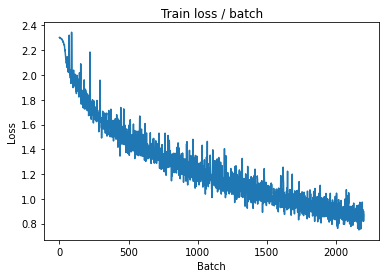


===============> Total time 19s	Avg loss 0.8421	Avg Prec@1 70.79 %	Avg Prec@5 97.63 %

[EVAL Batch 000/020]	Time 0.425s (0.425s)	Loss 0.8957 (0.8957)	Prec@1  68.4 ( 68.4)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.9089	Avg Prec@1 68.17 %	Avg Prec@5 97.18 %



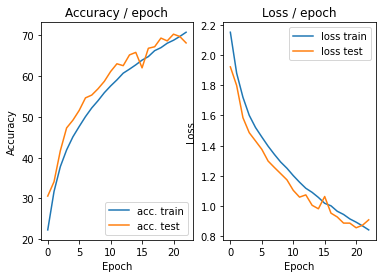

=== EPOCH 24 =====

[TRAIN Batch 000/100]	Time 0.519s (0.519s)	Loss 0.9587 (0.9587)	Prec@1  65.8 ( 65.8)	Prec@5  96.8 ( 96.8)


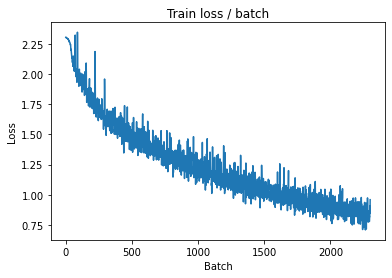


===============> Total time 19s	Avg loss 0.8306	Avg Prec@1 71.20 %	Avg Prec@5 97.65 %

[EVAL Batch 000/020]	Time 0.429s (0.429s)	Loss 0.8869 (0.8869)	Prec@1  69.6 ( 69.6)	Prec@5  97.6 ( 97.6)

===============> Total time 3s	Avg loss 0.9154	Avg Prec@1 68.49 %	Avg Prec@5 96.39 %



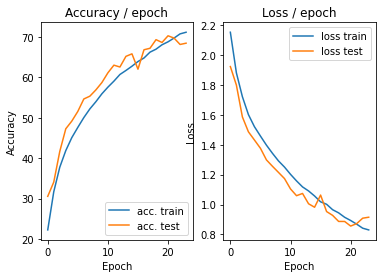

=== EPOCH 25 =====

[TRAIN Batch 000/100]	Time 0.537s (0.537s)	Loss 0.8360 (0.8360)	Prec@1  71.8 ( 71.8)	Prec@5  97.0 ( 97.0)


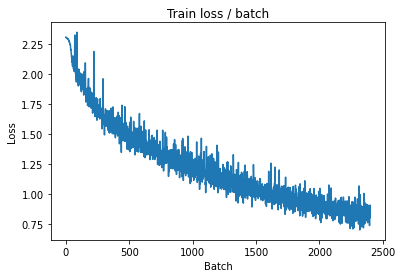


===============> Total time 19s	Avg loss 0.8091	Avg Prec@1 72.06 %	Avg Prec@5 97.87 %

[EVAL Batch 000/020]	Time 0.436s (0.436s)	Loss 0.7809 (0.7809)	Prec@1  71.8 ( 71.8)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.7807	Avg Prec@1 73.27 %	Avg Prec@5 98.11 %



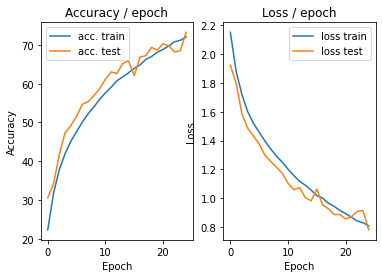

=== EPOCH 26 =====

[TRAIN Batch 000/100]	Time 0.724s (0.724s)	Loss 0.7479 (0.7479)	Prec@1  74.4 ( 74.4)	Prec@5  98.2 ( 98.2)


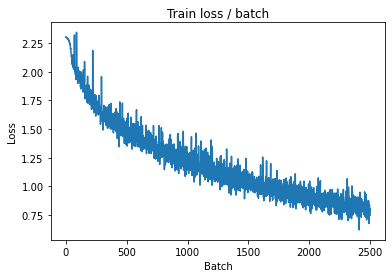


===============> Total time 19s	Avg loss 0.7882	Avg Prec@1 72.35 %	Avg Prec@5 98.04 %

[EVAL Batch 000/020]	Time 0.460s (0.460s)	Loss 0.7436 (0.7436)	Prec@1  71.6 ( 71.6)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.7610	Avg Prec@1 73.69 %	Avg Prec@5 98.01 %



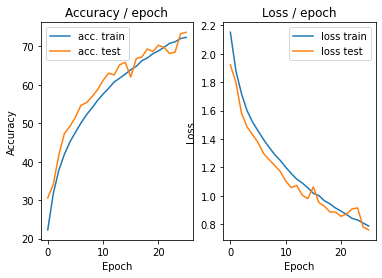

=== EPOCH 27 =====

[TRAIN Batch 000/100]	Time 0.563s (0.563s)	Loss 0.6758 (0.6758)	Prec@1  75.0 ( 75.0)	Prec@5  97.8 ( 97.8)


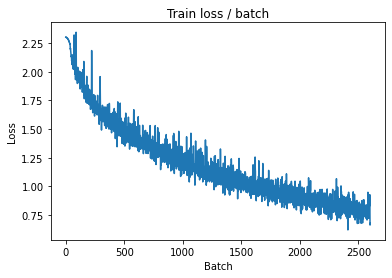


===============> Total time 19s	Avg loss 0.7702	Avg Prec@1 73.18 %	Avg Prec@5 98.04 %

[EVAL Batch 000/020]	Time 0.432s (0.432s)	Loss 0.7857 (0.7857)	Prec@1  72.8 ( 72.8)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.7933	Avg Prec@1 72.55 %	Avg Prec@5 97.98 %



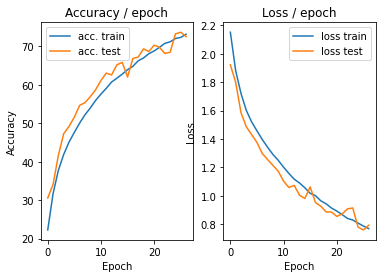

=== EPOCH 28 =====

[TRAIN Batch 000/100]	Time 0.524s (0.524s)	Loss 0.8035 (0.8035)	Prec@1  72.2 ( 72.2)	Prec@5  97.2 ( 97.2)


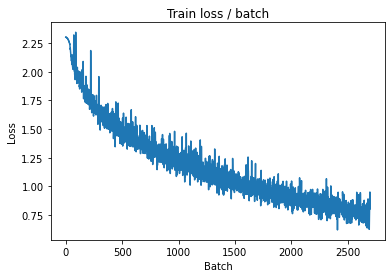


===============> Total time 19s	Avg loss 0.7543	Avg Prec@1 73.67 %	Avg Prec@5 98.16 %

[EVAL Batch 000/020]	Time 0.455s (0.455s)	Loss 0.7529 (0.7529)	Prec@1  72.6 ( 72.6)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.7622	Avg Prec@1 73.14 %	Avg Prec@5 98.19 %



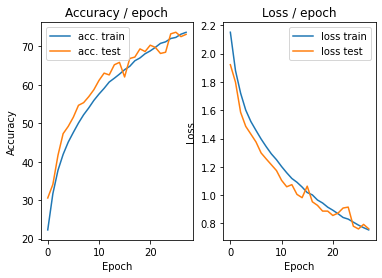

=== EPOCH 29 =====

[TRAIN Batch 000/100]	Time 0.534s (0.534s)	Loss 0.6881 (0.6881)	Prec@1  78.6 ( 78.6)	Prec@5  98.4 ( 98.4)


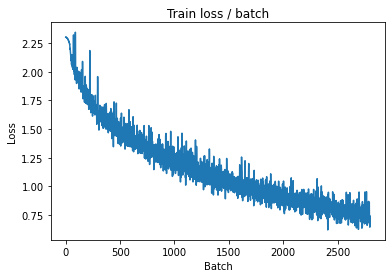


===============> Total time 19s	Avg loss 0.7386	Avg Prec@1 74.26 %	Avg Prec@5 98.24 %

[EVAL Batch 000/020]	Time 0.414s (0.414s)	Loss 0.7199 (0.7199)	Prec@1  73.4 ( 73.4)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.7406	Avg Prec@1 74.49 %	Avg Prec@5 98.14 %



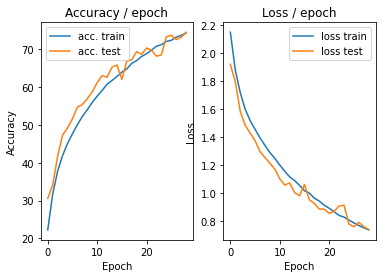

=== EPOCH 30 =====

[TRAIN Batch 000/100]	Time 0.538s (0.538s)	Loss 0.6624 (0.6624)	Prec@1  76.2 ( 76.2)	Prec@5  98.4 ( 98.4)


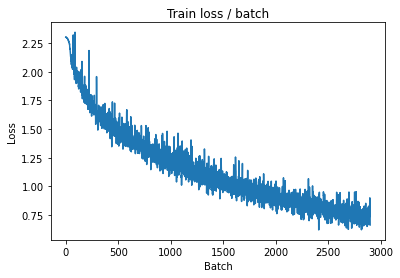


===============> Total time 19s	Avg loss 0.7265	Avg Prec@1 74.56 %	Avg Prec@5 98.30 %

[EVAL Batch 000/020]	Time 0.440s (0.440s)	Loss 0.7910 (0.7910)	Prec@1  71.2 ( 71.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.8108	Avg Prec@1 71.52 %	Avg Prec@5 97.94 %



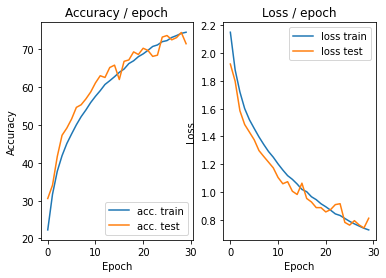

=== EPOCH 31 =====

[TRAIN Batch 000/100]	Time 0.527s (0.527s)	Loss 0.6789 (0.6789)	Prec@1  76.0 ( 76.0)	Prec@5  99.0 ( 99.0)


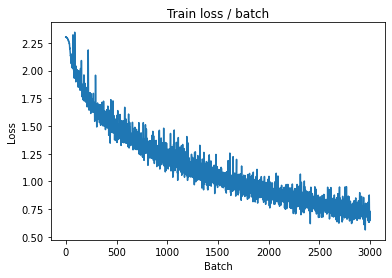


===============> Total time 19s	Avg loss 0.7105	Avg Prec@1 75.26 %	Avg Prec@5 98.37 %

[EVAL Batch 000/020]	Time 0.684s (0.684s)	Loss 0.7485 (0.7485)	Prec@1  74.0 ( 74.0)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.7518	Avg Prec@1 73.89 %	Avg Prec@5 98.02 %



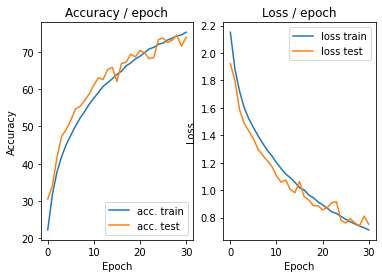

=== EPOCH 32 =====

[TRAIN Batch 000/100]	Time 0.536s (0.536s)	Loss 0.7267 (0.7267)	Prec@1  76.2 ( 76.2)	Prec@5  97.8 ( 97.8)


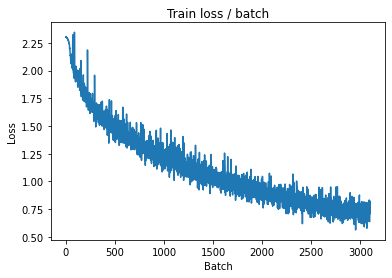


===============> Total time 19s	Avg loss 0.6925	Avg Prec@1 76.04 %	Avg Prec@5 98.38 %

[EVAL Batch 000/020]	Time 0.447s (0.447s)	Loss 0.7127 (0.7127)	Prec@1  73.0 ( 73.0)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.7338	Avg Prec@1 74.69 %	Avg Prec@5 98.10 %



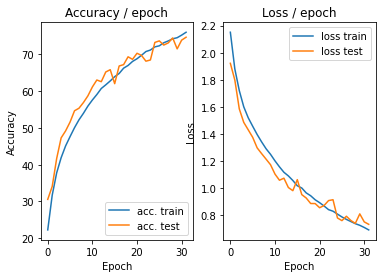

=== EPOCH 33 =====

[TRAIN Batch 000/100]	Time 0.521s (0.521s)	Loss 0.7001 (0.7001)	Prec@1  75.8 ( 75.8)	Prec@5  99.0 ( 99.0)


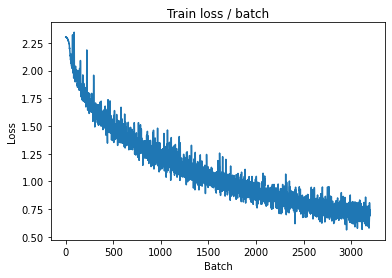


===============> Total time 19s	Avg loss 0.6831	Avg Prec@1 76.29 %	Avg Prec@5 98.54 %

[EVAL Batch 000/020]	Time 0.454s (0.454s)	Loss 0.6974 (0.6974)	Prec@1  74.2 ( 74.2)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.7144	Avg Prec@1 74.91 %	Avg Prec@5 98.22 %



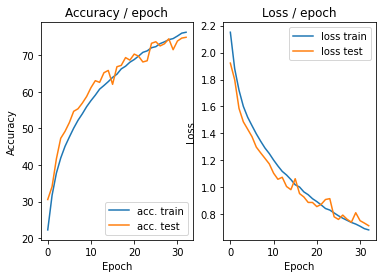

=== EPOCH 34 =====

[TRAIN Batch 000/100]	Time 0.550s (0.550s)	Loss 0.6347 (0.6347)	Prec@1  79.0 ( 79.0)	Prec@5  98.4 ( 98.4)


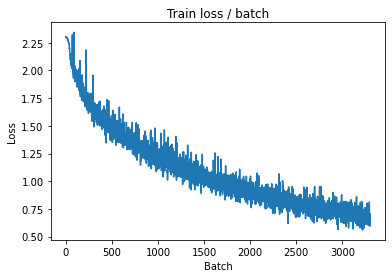


===============> Total time 19s	Avg loss 0.6731	Avg Prec@1 76.38 %	Avg Prec@5 98.52 %

[EVAL Batch 000/020]	Time 0.436s (0.436s)	Loss 0.6962 (0.6962)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.7034	Avg Prec@1 75.62 %	Avg Prec@5 98.24 %



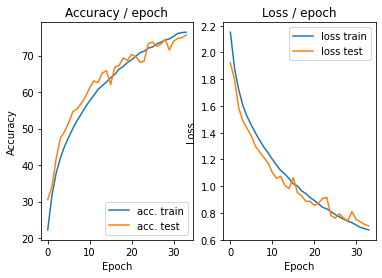

=== EPOCH 35 =====

[TRAIN Batch 000/100]	Time 0.562s (0.562s)	Loss 0.6592 (0.6592)	Prec@1  76.2 ( 76.2)	Prec@5  98.8 ( 98.8)


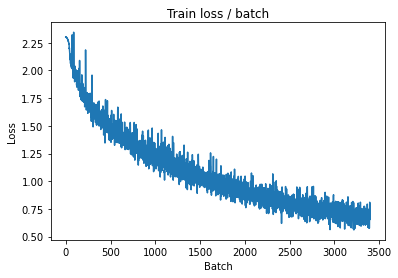


===============> Total time 19s	Avg loss 0.6567	Avg Prec@1 77.24 %	Avg Prec@5 98.65 %

[EVAL Batch 000/020]	Time 0.450s (0.450s)	Loss 0.6858 (0.6858)	Prec@1  74.8 ( 74.8)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.7023	Avg Prec@1 75.48 %	Avg Prec@5 98.52 %



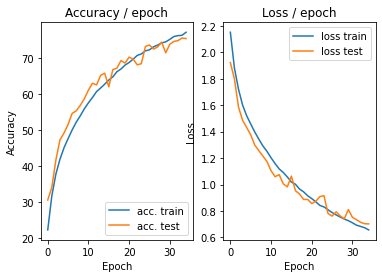

=== EPOCH 36 =====

[TRAIN Batch 000/100]	Time 0.517s (0.517s)	Loss 0.6491 (0.6491)	Prec@1  76.6 ( 76.6)	Prec@5  99.2 ( 99.2)


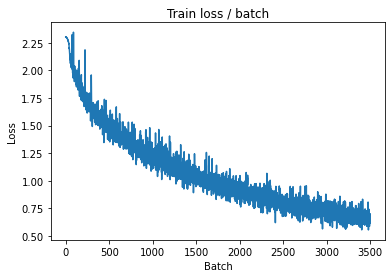


===============> Total time 19s	Avg loss 0.6387	Avg Prec@1 77.68 %	Avg Prec@5 98.70 %

[EVAL Batch 000/020]	Time 0.646s (0.646s)	Loss 0.6508 (0.6508)	Prec@1  75.2 ( 75.2)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.6762	Avg Prec@1 76.59 %	Avg Prec@5 98.32 %



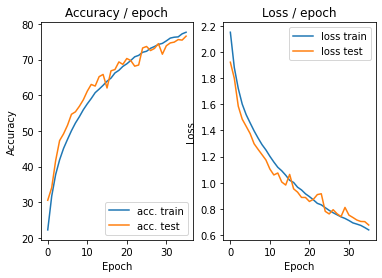

=== EPOCH 37 =====

[TRAIN Batch 000/100]	Time 0.552s (0.552s)	Loss 0.6227 (0.6227)	Prec@1  79.4 ( 79.4)	Prec@5  98.8 ( 98.8)


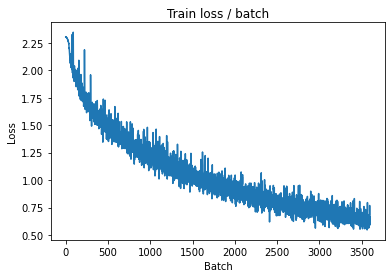


===============> Total time 19s	Avg loss 0.6332	Avg Prec@1 78.05 %	Avg Prec@5 98.76 %

[EVAL Batch 000/020]	Time 0.457s (0.457s)	Loss 0.6617 (0.6617)	Prec@1  75.0 ( 75.0)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6677	Avg Prec@1 76.44 %	Avg Prec@5 98.57 %



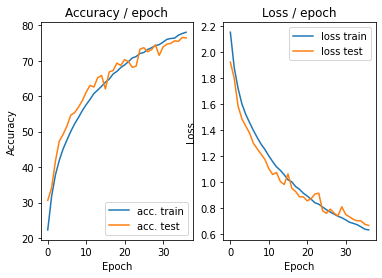

=== EPOCH 38 =====

[TRAIN Batch 000/100]	Time 0.552s (0.552s)	Loss 0.6410 (0.6410)	Prec@1  79.0 ( 79.0)	Prec@5  98.4 ( 98.4)


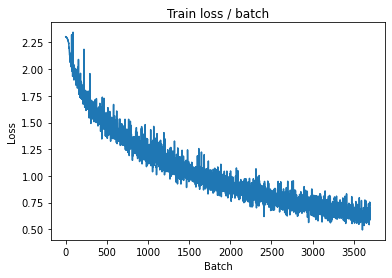


===============> Total time 19s	Avg loss 0.6178	Avg Prec@1 78.38 %	Avg Prec@5 98.84 %

[EVAL Batch 000/020]	Time 0.435s (0.435s)	Loss 0.7065 (0.7065)	Prec@1  72.8 ( 72.8)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.7182	Avg Prec@1 74.81 %	Avg Prec@5 98.28 %



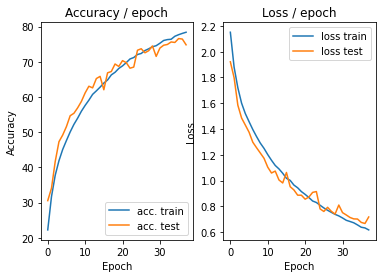

=== EPOCH 39 =====

[TRAIN Batch 000/100]	Time 0.539s (0.539s)	Loss 0.6908 (0.6908)	Prec@1  75.8 ( 75.8)	Prec@5  99.6 ( 99.6)


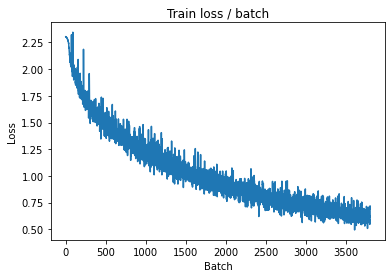


===============> Total time 19s	Avg loss 0.6153	Avg Prec@1 78.62 %	Avg Prec@5 98.82 %

[EVAL Batch 000/020]	Time 0.421s (0.421s)	Loss 0.6553 (0.6553)	Prec@1  75.6 ( 75.6)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.6622	Avg Prec@1 77.14 %	Avg Prec@5 98.56 %



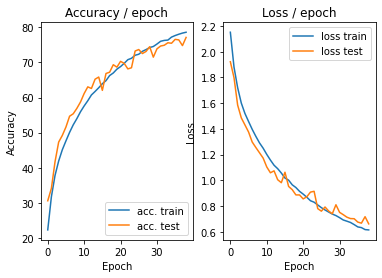

=== EPOCH 40 =====

[TRAIN Batch 000/100]	Time 0.550s (0.550s)	Loss 0.6176 (0.6176)	Prec@1  78.0 ( 78.0)	Prec@5  98.0 ( 98.0)


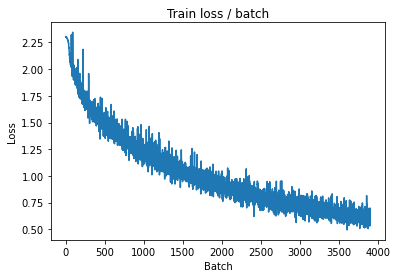


===============> Total time 19s	Avg loss 0.6014	Avg Prec@1 78.90 %	Avg Prec@5 98.93 %

[EVAL Batch 000/020]	Time 0.435s (0.435s)	Loss 0.6741 (0.6741)	Prec@1  76.6 ( 76.6)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6768	Avg Prec@1 76.40 %	Avg Prec@5 98.58 %



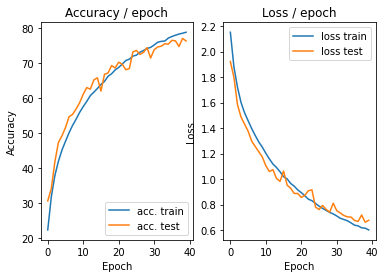

=== EPOCH 41 =====

[TRAIN Batch 000/100]	Time 0.529s (0.529s)	Loss 0.5367 (0.5367)	Prec@1  81.0 ( 81.0)	Prec@5  99.4 ( 99.4)


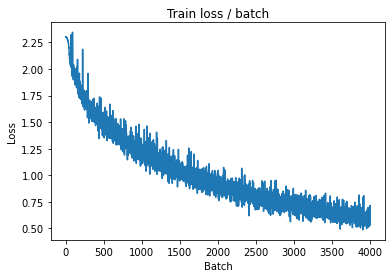


===============> Total time 19s	Avg loss 0.5860	Avg Prec@1 79.66 %	Avg Prec@5 98.90 %

[EVAL Batch 000/020]	Time 0.628s (0.628s)	Loss 0.6976 (0.6976)	Prec@1  75.0 ( 75.0)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.7165	Avg Prec@1 74.48 %	Avg Prec@5 98.38 %



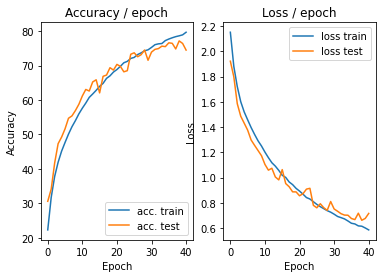

=== EPOCH 42 =====

[TRAIN Batch 000/100]	Time 0.539s (0.539s)	Loss 0.5931 (0.5931)	Prec@1  77.6 ( 77.6)	Prec@5  99.6 ( 99.6)


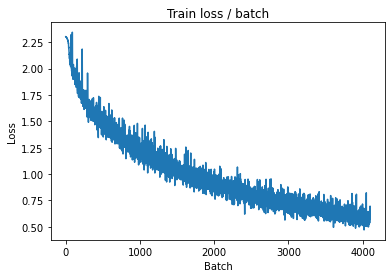


===============> Total time 19s	Avg loss 0.5746	Avg Prec@1 80.04 %	Avg Prec@5 99.00 %

[EVAL Batch 000/020]	Time 0.429s (0.429s)	Loss 0.6550 (0.6550)	Prec@1  78.4 ( 78.4)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.6521	Avg Prec@1 77.62 %	Avg Prec@5 98.58 %



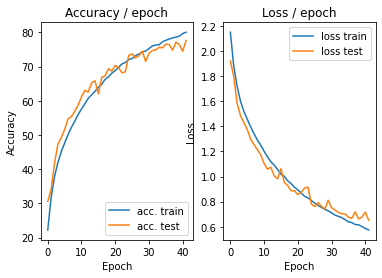

=== EPOCH 43 =====

[TRAIN Batch 000/100]	Time 0.566s (0.566s)	Loss 0.5113 (0.5113)	Prec@1  84.0 ( 84.0)	Prec@5  99.2 ( 99.2)


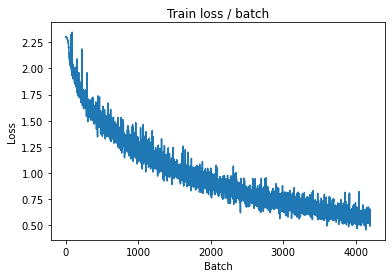


===============> Total time 19s	Avg loss 0.5758	Avg Prec@1 80.03 %	Avg Prec@5 99.00 %

[EVAL Batch 000/020]	Time 0.432s (0.432s)	Loss 0.6430 (0.6430)	Prec@1  76.8 ( 76.8)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6441	Avg Prec@1 77.74 %	Avg Prec@5 98.66 %



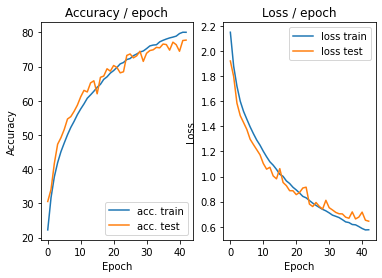

=== EPOCH 44 =====

[TRAIN Batch 000/100]	Time 0.544s (0.544s)	Loss 0.5504 (0.5504)	Prec@1  79.8 ( 79.8)	Prec@5  99.4 ( 99.4)


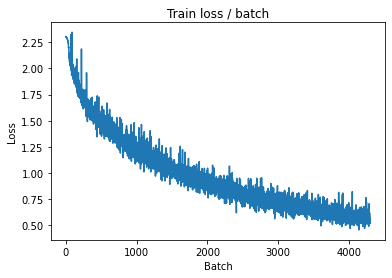


===============> Total time 19s	Avg loss 0.5585	Avg Prec@1 80.55 %	Avg Prec@5 98.97 %

[EVAL Batch 000/020]	Time 0.445s (0.445s)	Loss 0.6256 (0.6256)	Prec@1  77.0 ( 77.0)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.6485	Avg Prec@1 77.45 %	Avg Prec@5 98.78 %



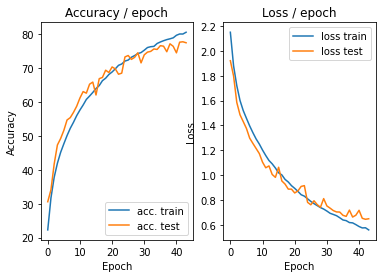

=== EPOCH 45 =====

[TRAIN Batch 000/100]	Time 0.543s (0.543s)	Loss 0.5177 (0.5177)	Prec@1  82.4 ( 82.4)	Prec@5  99.4 ( 99.4)


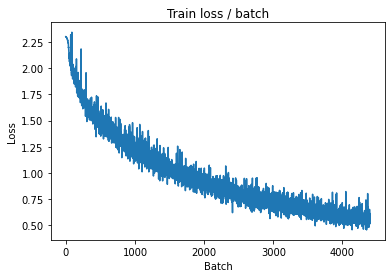


===============> Total time 19s	Avg loss 0.5507	Avg Prec@1 80.74 %	Avg Prec@5 99.09 %

[EVAL Batch 000/020]	Time 0.457s (0.457s)	Loss 0.6586 (0.6586)	Prec@1  77.2 ( 77.2)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.6408	Avg Prec@1 78.15 %	Avg Prec@5 98.66 %



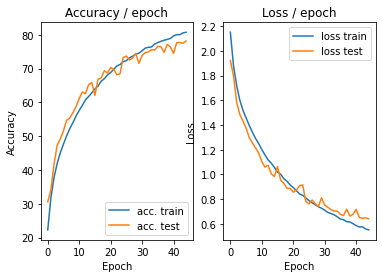

=== EPOCH 46 =====

[TRAIN Batch 000/100]	Time 0.756s (0.756s)	Loss 0.5006 (0.5006)	Prec@1  83.6 ( 83.6)	Prec@5  99.4 ( 99.4)


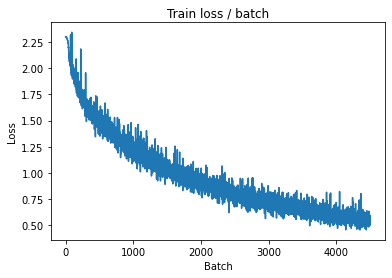


===============> Total time 19s	Avg loss 0.5396	Avg Prec@1 81.18 %	Avg Prec@5 99.14 %

[EVAL Batch 000/020]	Time 0.445s (0.445s)	Loss 0.7002 (0.7002)	Prec@1  75.4 ( 75.4)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.6907	Avg Prec@1 76.36 %	Avg Prec@5 98.43 %



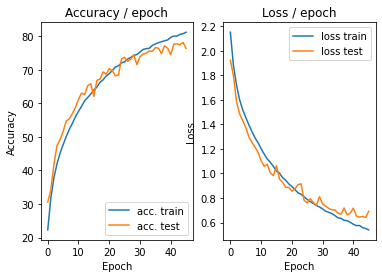

=== EPOCH 47 =====

[TRAIN Batch 000/100]	Time 0.548s (0.548s)	Loss 0.5975 (0.5975)	Prec@1  79.6 ( 79.6)	Prec@5  98.8 ( 98.8)


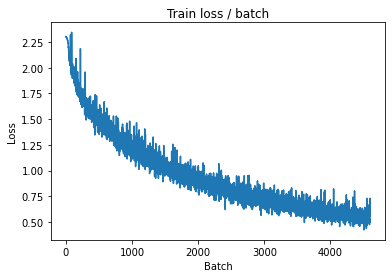


===============> Total time 19s	Avg loss 0.5325	Avg Prec@1 81.43 %	Avg Prec@5 99.18 %

[EVAL Batch 000/020]	Time 0.435s (0.435s)	Loss 0.6697 (0.6697)	Prec@1  77.2 ( 77.2)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.6662	Avg Prec@1 77.66 %	Avg Prec@5 98.49 %



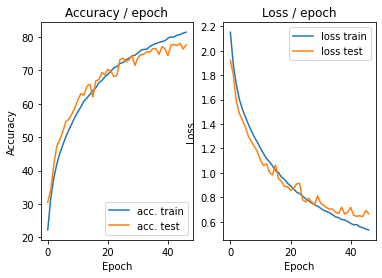

=== EPOCH 48 =====

[TRAIN Batch 000/100]	Time 0.560s (0.560s)	Loss 0.5482 (0.5482)	Prec@1  82.6 ( 82.6)	Prec@5  99.0 ( 99.0)


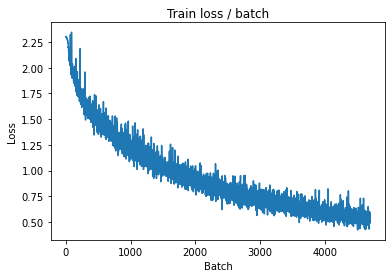


===============> Total time 19s	Avg loss 0.5287	Avg Prec@1 81.55 %	Avg Prec@5 99.12 %

[EVAL Batch 000/020]	Time 0.439s (0.439s)	Loss 0.6295 (0.6295)	Prec@1  77.2 ( 77.2)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6306	Avg Prec@1 78.13 %	Avg Prec@5 98.60 %



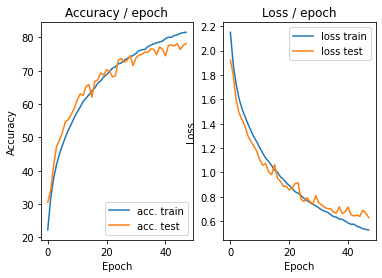

=== EPOCH 49 =====

[TRAIN Batch 000/100]	Time 0.521s (0.521s)	Loss 0.5422 (0.5422)	Prec@1  81.6 ( 81.6)	Prec@5  99.2 ( 99.2)


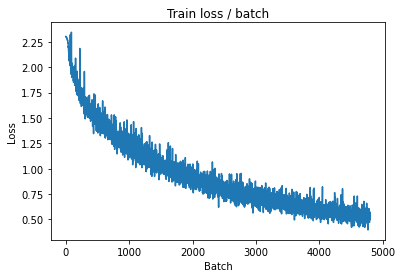


===============> Total time 19s	Avg loss 0.5114	Avg Prec@1 82.20 %	Avg Prec@5 99.22 %

[EVAL Batch 000/020]	Time 0.439s (0.439s)	Loss 0.6547 (0.6547)	Prec@1  74.0 ( 74.0)	Prec@5  98.2 ( 98.2)

===============> Total time 3s	Avg loss 0.6540	Avg Prec@1 77.15 %	Avg Prec@5 98.60 %



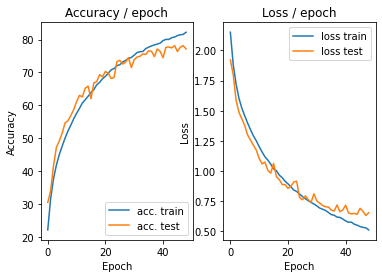

=== EPOCH 50 =====

[TRAIN Batch 000/100]	Time 0.567s (0.567s)	Loss 0.5754 (0.5754)	Prec@1  80.4 ( 80.4)	Prec@5  99.2 ( 99.2)


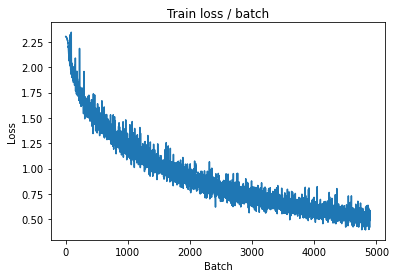


===============> Total time 19s	Avg loss 0.5063	Avg Prec@1 82.43 %	Avg Prec@5 99.20 %

[EVAL Batch 000/020]	Time 0.431s (0.431s)	Loss 0.6538 (0.6538)	Prec@1  76.6 ( 76.6)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.6372	Avg Prec@1 78.09 %	Avg Prec@5 98.69 %



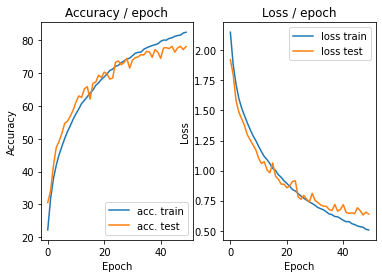

In [ ]:
main(500, 0.05, epochs= 50,cuda=True)

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode =True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(p=0.5)
  
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201]),
            transforms.CenterCrop(28)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()
        

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        lr_sched.step()
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/100]	Time 0.525s (0.525s)	Loss 2.3015 (2.3015)	Prec@1   8.2 (  8.2)	Prec@5  52.4 ( 52.4)


<Figure size 432x288 with 0 Axes>

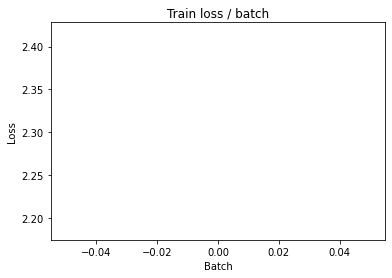


===============> Total time 19s	Avg loss 1.9086	Avg Prec@1 29.42 %	Avg Prec@5 80.41 %

[EVAL Batch 000/020]	Time 0.420s (0.420s)	Loss 1.5151 (1.5151)	Prec@1  43.0 ( 43.0)	Prec@5  91.6 ( 91.6)

===============> Total time 3s	Avg loss 1.4956	Avg Prec@1 45.09 %	Avg Prec@5 92.15 %



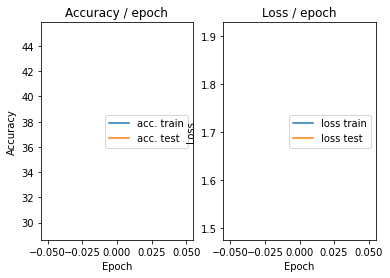

=== EPOCH 2 =====

[TRAIN Batch 000/100]	Time 0.505s (0.505s)	Loss 1.5784 (1.5784)	Prec@1  41.4 ( 41.4)	Prec@5  90.4 ( 90.4)


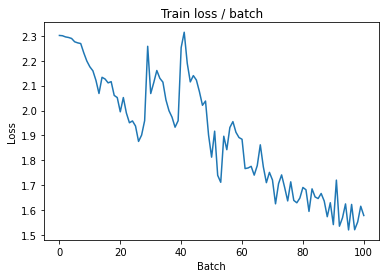


===============> Total time 19s	Avg loss 1.3832	Avg Prec@1 50.09 %	Avg Prec@5 93.36 %

[EVAL Batch 000/020]	Time 0.639s (0.639s)	Loss 1.2644 (1.2644)	Prec@1  57.2 ( 57.2)	Prec@5  95.8 ( 95.8)

===============> Total time 3s	Avg loss 1.2867	Avg Prec@1 54.46 %	Avg Prec@5 94.68 %



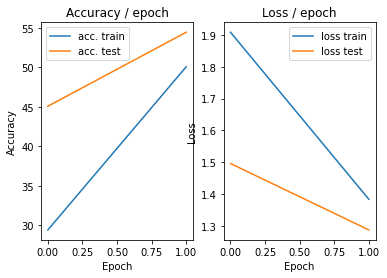

=== EPOCH 3 =====

[TRAIN Batch 000/100]	Time 0.509s (0.509s)	Loss 1.2910 (1.2910)	Prec@1  55.0 ( 55.0)	Prec@5  95.0 ( 95.0)


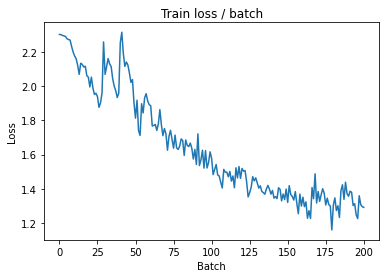


===============> Total time 19s	Avg loss 1.1483	Avg Prec@1 59.39 %	Avg Prec@5 95.60 %

[EVAL Batch 000/020]	Time 0.430s (0.430s)	Loss 1.0570 (1.0570)	Prec@1  62.2 ( 62.2)	Prec@5  96.8 ( 96.8)

===============> Total time 3s	Avg loss 1.0239	Avg Prec@1 64.18 %	Avg Prec@5 96.57 %



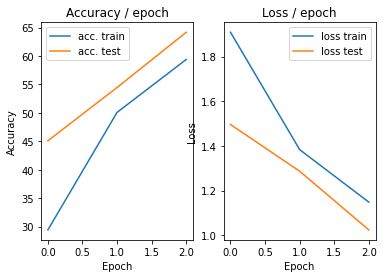

=== EPOCH 4 =====

[TRAIN Batch 000/100]	Time 0.509s (0.509s)	Loss 0.9977 (0.9977)	Prec@1  61.4 ( 61.4)	Prec@5  97.0 ( 97.0)


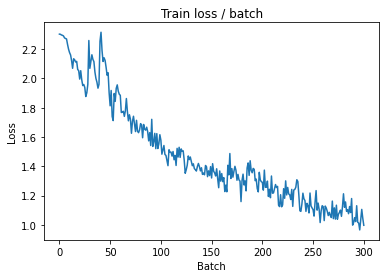


===============> Total time 19s	Avg loss 1.0056	Avg Prec@1 64.49 %	Avg Prec@5 96.61 %

[EVAL Batch 000/020]	Time 0.422s (0.422s)	Loss 0.9538 (0.9538)	Prec@1  66.4 ( 66.4)	Prec@5  97.4 ( 97.4)

===============> Total time 3s	Avg loss 0.9167	Avg Prec@1 68.12 %	Avg Prec@5 97.21 %



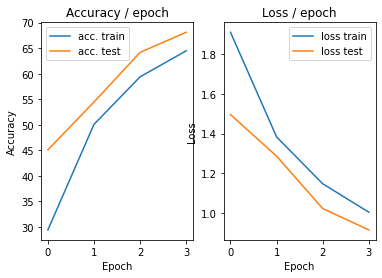

=== EPOCH 5 =====

[TRAIN Batch 000/100]	Time 0.527s (0.527s)	Loss 0.9077 (0.9077)	Prec@1  69.6 ( 69.6)	Prec@5  96.2 ( 96.2)


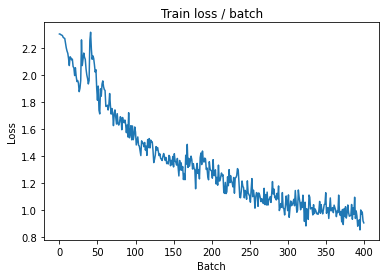


===============> Total time 19s	Avg loss 0.8981	Avg Prec@1 68.75 %	Avg Prec@5 97.29 %

[EVAL Batch 000/020]	Time 0.425s (0.425s)	Loss 0.8470 (0.8470)	Prec@1  70.8 ( 70.8)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.8565	Avg Prec@1 70.34 %	Avg Prec@5 97.43 %



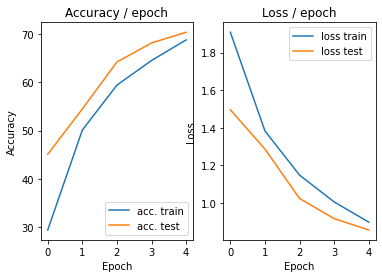

=== EPOCH 6 =====

[TRAIN Batch 000/100]	Time 0.495s (0.495s)	Loss 0.9240 (0.9240)	Prec@1  70.0 ( 70.0)	Prec@5  97.2 ( 97.2)


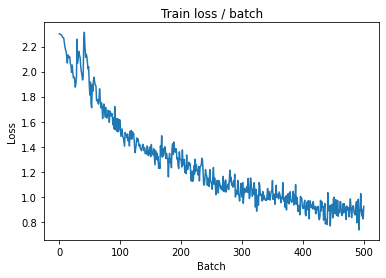


===============> Total time 19s	Avg loss 0.8107	Avg Prec@1 71.57 %	Avg Prec@5 97.89 %

[EVAL Batch 000/020]	Time 0.442s (0.442s)	Loss 0.8158 (0.8158)	Prec@1  71.8 ( 71.8)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.8110	Avg Prec@1 71.78 %	Avg Prec@5 97.74 %



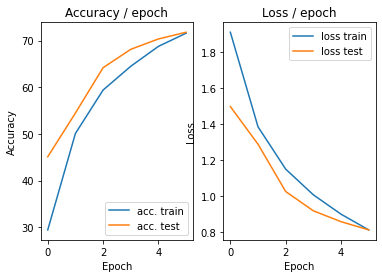

=== EPOCH 7 =====

[TRAIN Batch 000/100]	Time 0.544s (0.544s)	Loss 0.7431 (0.7431)	Prec@1  73.2 ( 73.2)	Prec@5  98.4 ( 98.4)


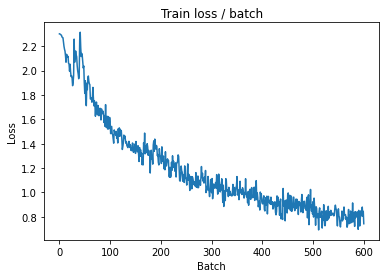


===============> Total time 19s	Avg loss 0.7529	Avg Prec@1 73.67 %	Avg Prec@5 98.22 %

[EVAL Batch 000/020]	Time 0.665s (0.665s)	Loss 0.7897 (0.7897)	Prec@1  74.2 ( 74.2)	Prec@5  98.2 ( 98.2)

===============> Total time 3s	Avg loss 0.7838	Avg Prec@1 73.32 %	Avg Prec@5 97.88 %



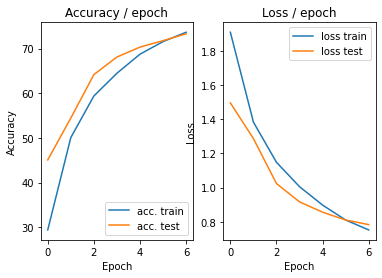

=== EPOCH 8 =====

[TRAIN Batch 000/100]	Time 0.513s (0.513s)	Loss 0.7728 (0.7728)	Prec@1  76.0 ( 76.0)	Prec@5  97.8 ( 97.8)


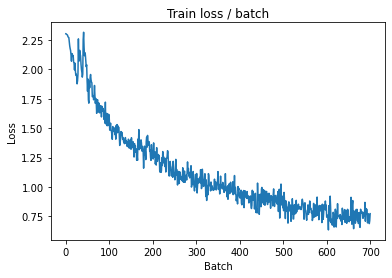


===============> Total time 19s	Avg loss 0.7072	Avg Prec@1 75.39 %	Avg Prec@5 98.45 %

[EVAL Batch 000/020]	Time 0.469s (0.469s)	Loss 0.7942 (0.7942)	Prec@1  75.0 ( 75.0)	Prec@5  97.6 ( 97.6)

===============> Total time 3s	Avg loss 0.7412	Avg Prec@1 75.05 %	Avg Prec@5 97.91 %



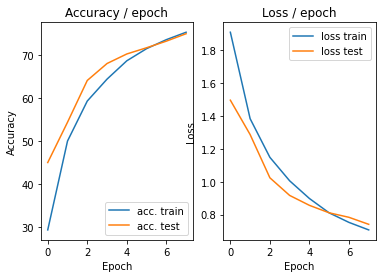

=== EPOCH 9 =====

[TRAIN Batch 000/100]	Time 0.506s (0.506s)	Loss 0.6604 (0.6604)	Prec@1  76.6 ( 76.6)	Prec@5  98.2 ( 98.2)


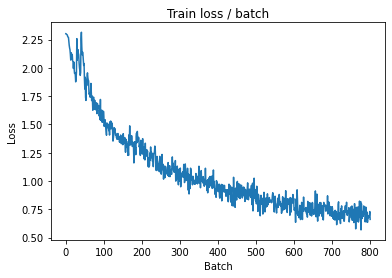


===============> Total time 19s	Avg loss 0.6764	Avg Prec@1 76.54 %	Avg Prec@5 98.54 %

[EVAL Batch 000/020]	Time 0.417s (0.417s)	Loss 0.7522 (0.7522)	Prec@1  75.0 ( 75.0)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.7334	Avg Prec@1 74.93 %	Avg Prec@5 98.13 %



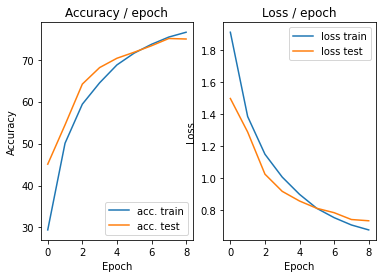

=== EPOCH 10 =====

[TRAIN Batch 000/100]	Time 0.524s (0.524s)	Loss 0.7158 (0.7158)	Prec@1  76.2 ( 76.2)	Prec@5  99.0 ( 99.0)


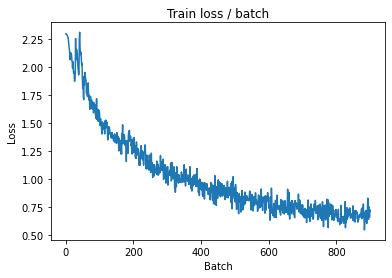


===============> Total time 19s	Avg loss 0.6247	Avg Prec@1 78.50 %	Avg Prec@5 98.77 %

[EVAL Batch 000/020]	Time 0.450s (0.450s)	Loss 0.7257 (0.7257)	Prec@1  76.8 ( 76.8)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.7005	Avg Prec@1 75.85 %	Avg Prec@5 98.22 %



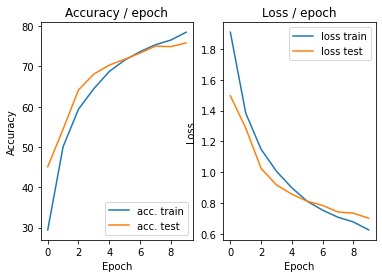

=== EPOCH 11 =====

[TRAIN Batch 000/100]	Time 0.525s (0.525s)	Loss 0.6450 (0.6450)	Prec@1  76.2 ( 76.2)	Prec@5  98.2 ( 98.2)


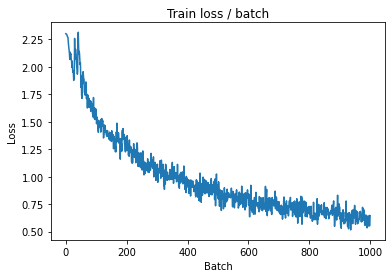


===============> Total time 19s	Avg loss 0.5905	Avg Prec@1 79.54 %	Avg Prec@5 98.92 %

[EVAL Batch 000/020]	Time 0.428s (0.428s)	Loss 0.6826 (0.6826)	Prec@1  76.0 ( 76.0)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.6789	Avg Prec@1 77.50 %	Avg Prec@5 98.40 %



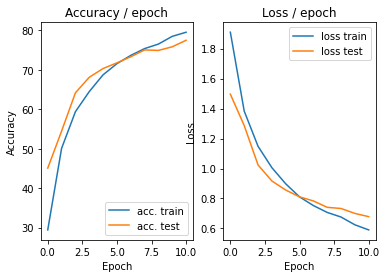

=== EPOCH 12 =====

[TRAIN Batch 000/100]	Time 0.506s (0.506s)	Loss 0.5686 (0.5686)	Prec@1  80.4 ( 80.4)	Prec@5  98.8 ( 98.8)


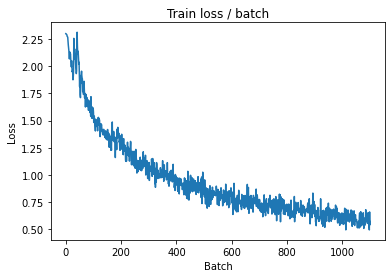


===============> Total time 19s	Avg loss 0.5588	Avg Prec@1 80.48 %	Avg Prec@5 99.08 %

[EVAL Batch 000/020]	Time 0.642s (0.642s)	Loss 0.7180 (0.7180)	Prec@1  76.6 ( 76.6)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.6921	Avg Prec@1 77.03 %	Avg Prec@5 98.08 %



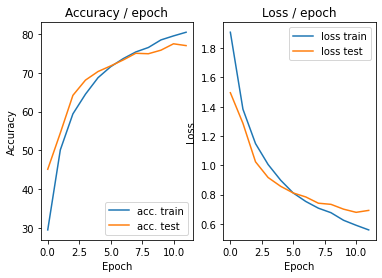

=== EPOCH 13 =====

[TRAIN Batch 000/100]	Time 0.536s (0.536s)	Loss 0.5755 (0.5755)	Prec@1  79.4 ( 79.4)	Prec@5  98.8 ( 98.8)


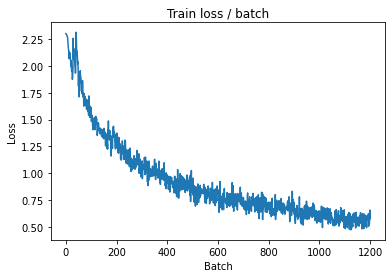


===============> Total time 19s	Avg loss 0.5256	Avg Prec@1 81.72 %	Avg Prec@5 99.18 %

[EVAL Batch 000/020]	Time 0.433s (0.433s)	Loss 0.7205 (0.7205)	Prec@1  79.4 ( 79.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6814	Avg Prec@1 77.86 %	Avg Prec@5 98.44 %



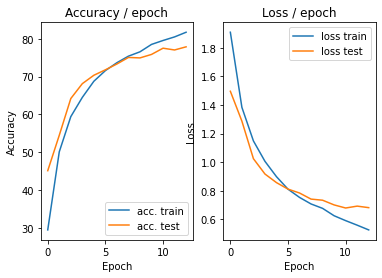

=== EPOCH 14 =====

[TRAIN Batch 000/100]	Time 0.533s (0.533s)	Loss 0.4799 (0.4799)	Prec@1  82.4 ( 82.4)	Prec@5  99.2 ( 99.2)


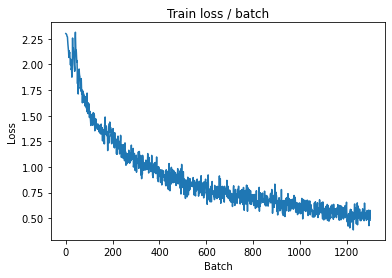


===============> Total time 19s	Avg loss 0.4895	Avg Prec@1 82.79 %	Avg Prec@5 99.36 %

[EVAL Batch 000/020]	Time 0.450s (0.450s)	Loss 0.6795 (0.6795)	Prec@1  78.0 ( 78.0)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6444	Avg Prec@1 78.50 %	Avg Prec@5 98.51 %



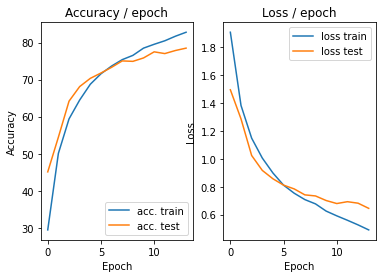

=== EPOCH 15 =====

[TRAIN Batch 000/100]	Time 0.523s (0.523s)	Loss 0.5052 (0.5052)	Prec@1  81.2 ( 81.2)	Prec@5  99.6 ( 99.6)


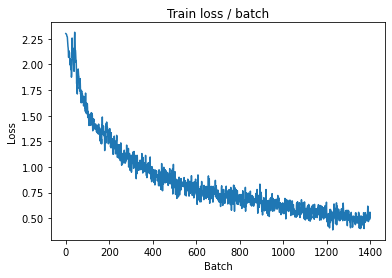


===============> Total time 19s	Avg loss 0.4748	Avg Prec@1 83.43 %	Avg Prec@5 99.33 %

[EVAL Batch 000/020]	Time 0.414s (0.414s)	Loss 0.7254 (0.7254)	Prec@1  77.0 ( 77.0)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6677	Avg Prec@1 78.83 %	Avg Prec@5 98.43 %



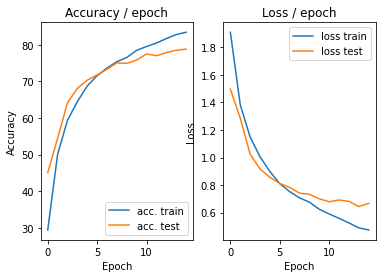

=== EPOCH 16 =====

[TRAIN Batch 000/100]	Time 0.511s (0.511s)	Loss 0.4813 (0.4813)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)


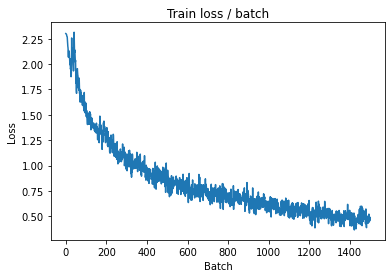


===============> Total time 19s	Avg loss 0.4493	Avg Prec@1 84.32 %	Avg Prec@5 99.44 %

[EVAL Batch 000/020]	Time 0.452s (0.452s)	Loss 0.6426 (0.6426)	Prec@1  77.6 ( 77.6)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.6304	Avg Prec@1 79.24 %	Avg Prec@5 98.69 %



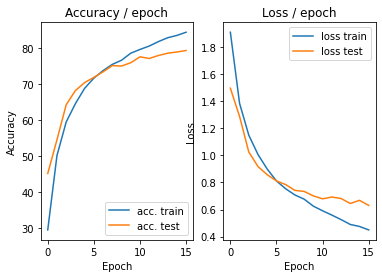

=== EPOCH 17 =====

[TRAIN Batch 000/100]	Time 0.508s (0.508s)	Loss 0.3601 (0.3601)	Prec@1  85.6 ( 85.6)	Prec@5  99.8 ( 99.8)


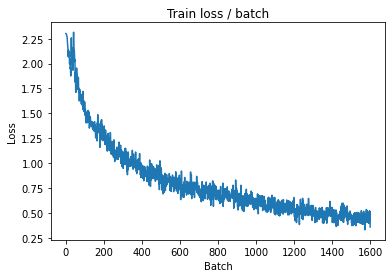


===============> Total time 19s	Avg loss 0.4188	Avg Prec@1 85.31 %	Avg Prec@5 99.46 %

[EVAL Batch 000/020]	Time 0.430s (0.430s)	Loss 0.7251 (0.7251)	Prec@1  76.8 ( 76.8)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6528	Avg Prec@1 79.23 %	Avg Prec@5 98.51 %



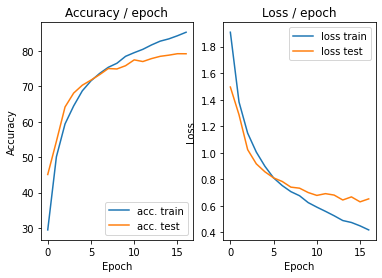

=== EPOCH 18 =====

[TRAIN Batch 000/100]	Time 0.737s (0.737s)	Loss 0.4142 (0.4142)	Prec@1  85.2 ( 85.2)	Prec@5  99.8 ( 99.8)


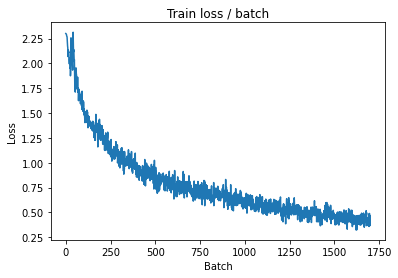


===============> Total time 19s	Avg loss 0.4023	Avg Prec@1 86.09 %	Avg Prec@5 99.56 %

[EVAL Batch 000/020]	Time 0.430s (0.430s)	Loss 0.6822 (0.6822)	Prec@1  79.2 ( 79.2)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6242	Avg Prec@1 79.74 %	Avg Prec@5 98.68 %



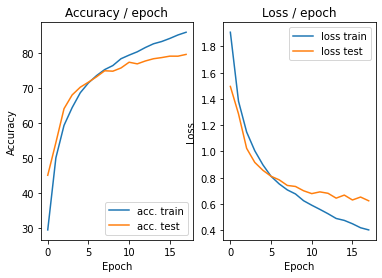

=== EPOCH 19 =====

[TRAIN Batch 000/100]	Time 0.541s (0.541s)	Loss 0.3710 (0.3710)	Prec@1  88.0 ( 88.0)	Prec@5  99.2 ( 99.2)


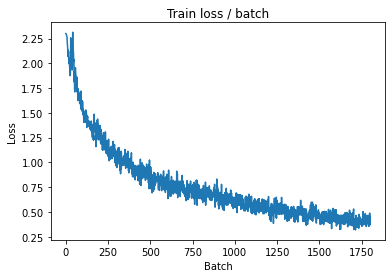


===============> Total time 19s	Avg loss 0.3850	Avg Prec@1 86.57 %	Avg Prec@5 99.64 %

[EVAL Batch 000/020]	Time 0.429s (0.429s)	Loss 0.6769 (0.6769)	Prec@1  78.8 ( 78.8)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6253	Avg Prec@1 80.19 %	Avg Prec@5 98.51 %



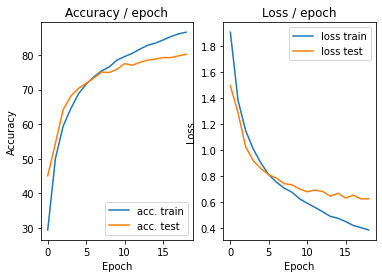

=== EPOCH 20 =====

[TRAIN Batch 000/100]	Time 0.517s (0.517s)	Loss 0.3305 (0.3305)	Prec@1  89.8 ( 89.8)	Prec@5  99.4 ( 99.4)


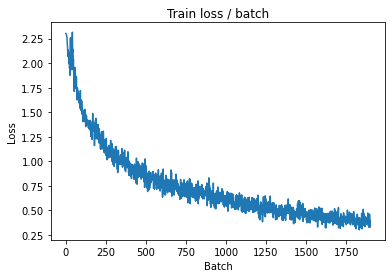


===============> Total time 19s	Avg loss 0.3529	Avg Prec@1 87.68 %	Avg Prec@5 99.65 %

[EVAL Batch 000/020]	Time 0.428s (0.428s)	Loss 0.6842 (0.6842)	Prec@1  78.2 ( 78.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6551	Avg Prec@1 79.75 %	Avg Prec@5 98.62 %



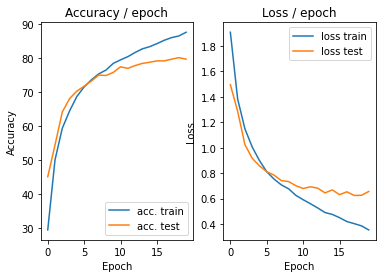

=== EPOCH 21 =====

[TRAIN Batch 000/100]	Time 0.524s (0.524s)	Loss 0.3215 (0.3215)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)


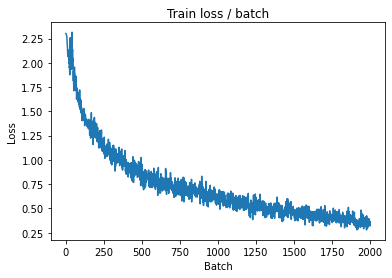


===============> Total time 19s	Avg loss 0.3435	Avg Prec@1 87.97 %	Avg Prec@5 99.70 %

[EVAL Batch 000/020]	Time 0.450s (0.450s)	Loss 0.7185 (0.7185)	Prec@1  79.0 ( 79.0)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.6420	Avg Prec@1 79.99 %	Avg Prec@5 98.52 %



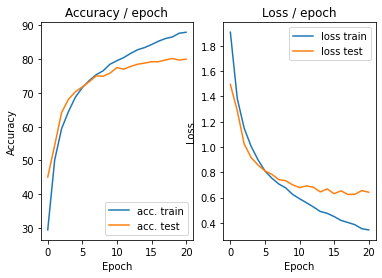

=== EPOCH 22 =====

[TRAIN Batch 000/100]	Time 0.550s (0.550s)	Loss 0.2978 (0.2978)	Prec@1  90.4 ( 90.4)	Prec@5  99.8 ( 99.8)


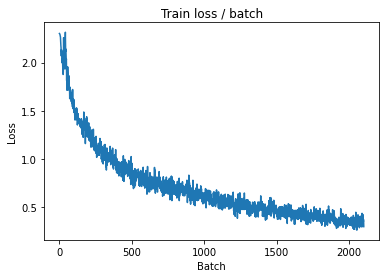


===============> Total time 19s	Avg loss 0.3192	Avg Prec@1 88.80 %	Avg Prec@5 99.73 %

[EVAL Batch 000/020]	Time 0.437s (0.437s)	Loss 0.7190 (0.7190)	Prec@1  81.2 ( 81.2)	Prec@5  97.6 ( 97.6)

===============> Total time 3s	Avg loss 0.6450	Avg Prec@1 80.46 %	Avg Prec@5 98.67 %



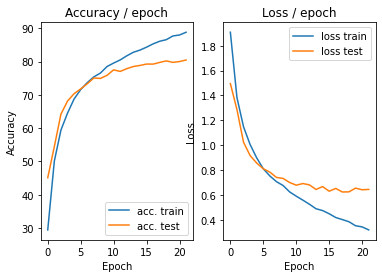

=== EPOCH 23 =====

[TRAIN Batch 000/100]	Time 0.720s (0.720s)	Loss 0.3800 (0.3800)	Prec@1  88.6 ( 88.6)	Prec@5 100.0 (100.0)


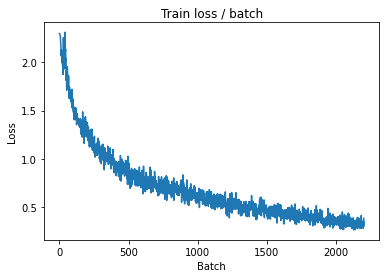


===============> Total time 19s	Avg loss 0.3019	Avg Prec@1 89.42 %	Avg Prec@5 99.76 %

[EVAL Batch 000/020]	Time 0.425s (0.425s)	Loss 0.7545 (0.7545)	Prec@1  79.0 ( 79.0)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.6682	Avg Prec@1 79.98 %	Avg Prec@5 98.56 %



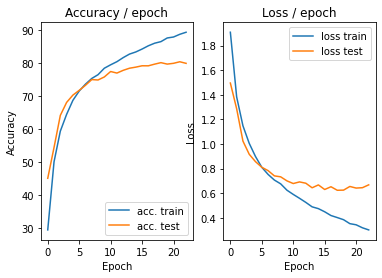

=== EPOCH 24 =====

[TRAIN Batch 000/100]	Time 0.544s (0.544s)	Loss 0.2787 (0.2787)	Prec@1  89.4 ( 89.4)	Prec@5 100.0 (100.0)


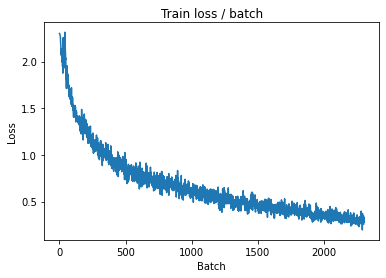


===============> Total time 19s	Avg loss 0.2878	Avg Prec@1 89.95 %	Avg Prec@5 99.80 %

[EVAL Batch 000/020]	Time 0.441s (0.441s)	Loss 0.6767 (0.6767)	Prec@1  79.6 ( 79.6)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.6502	Avg Prec@1 80.74 %	Avg Prec@5 98.72 %



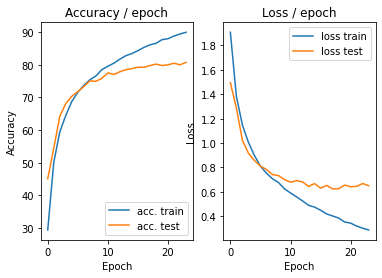

=== EPOCH 25 =====

[TRAIN Batch 000/100]	Time 0.537s (0.537s)	Loss 0.2447 (0.2447)	Prec@1  90.6 ( 90.6)	Prec@5  99.8 ( 99.8)


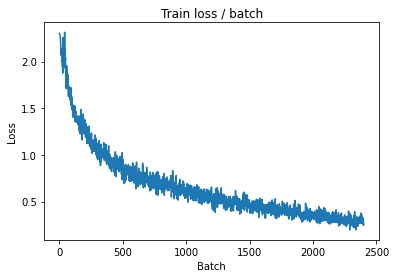


===============> Total time 19s	Avg loss 0.2712	Avg Prec@1 90.54 %	Avg Prec@5 99.81 %

[EVAL Batch 000/020]	Time 0.464s (0.464s)	Loss 0.6848 (0.6848)	Prec@1  80.4 ( 80.4)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6593	Avg Prec@1 80.74 %	Avg Prec@5 98.71 %



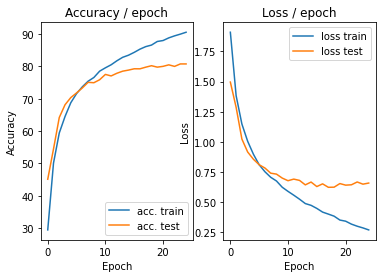

=== EPOCH 26 =====

[TRAIN Batch 000/100]	Time 0.496s (0.496s)	Loss 0.2644 (0.2644)	Prec@1  89.8 ( 89.8)	Prec@5  99.8 ( 99.8)


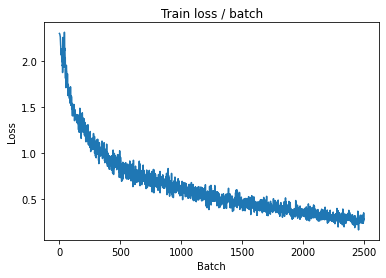


===============> Total time 19s	Avg loss 0.2569	Avg Prec@1 91.09 %	Avg Prec@5 99.86 %

[EVAL Batch 000/020]	Time 0.447s (0.447s)	Loss 0.6981 (0.6981)	Prec@1  80.4 ( 80.4)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.6611	Avg Prec@1 80.53 %	Avg Prec@5 98.75 %



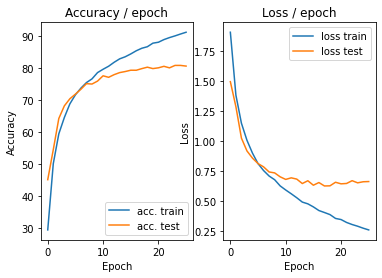

=== EPOCH 27 =====

[TRAIN Batch 000/100]	Time 0.530s (0.530s)	Loss 0.2469 (0.2469)	Prec@1  91.4 ( 91.4)	Prec@5 100.0 (100.0)


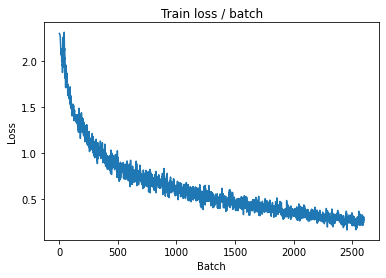


===============> Total time 19s	Avg loss 0.2427	Avg Prec@1 91.60 %	Avg Prec@5 99.86 %

[EVAL Batch 000/020]	Time 0.433s (0.433s)	Loss 0.6609 (0.6609)	Prec@1  80.6 ( 80.6)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6542	Avg Prec@1 81.23 %	Avg Prec@5 98.76 %



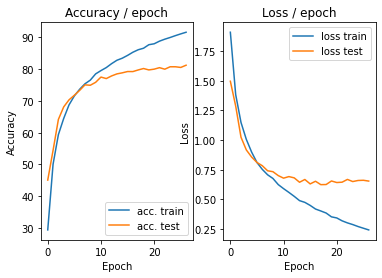

=== EPOCH 28 =====

[TRAIN Batch 000/100]	Time 0.508s (0.508s)	Loss 0.2301 (0.2301)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


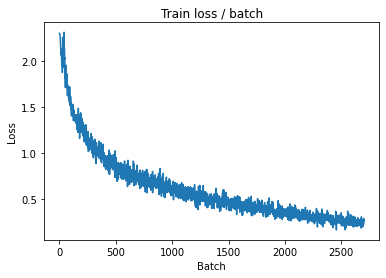


===============> Total time 19s	Avg loss 0.2310	Avg Prec@1 91.92 %	Avg Prec@5 99.87 %

[EVAL Batch 000/020]	Time 0.614s (0.614s)	Loss 0.7870 (0.7870)	Prec@1  79.2 ( 79.2)	Prec@5  98.2 ( 98.2)

===============> Total time 3s	Avg loss 0.6687	Avg Prec@1 81.43 %	Avg Prec@5 98.70 %



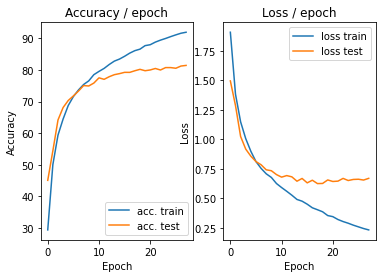

=== EPOCH 29 =====

[TRAIN Batch 000/100]	Time 0.531s (0.531s)	Loss 0.1915 (0.1915)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


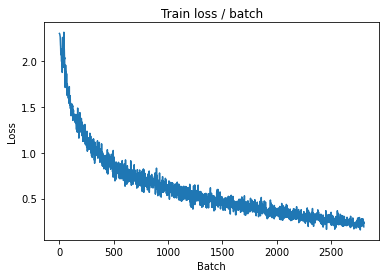


===============> Total time 19s	Avg loss 0.2150	Avg Prec@1 92.46 %	Avg Prec@5 99.92 %

[EVAL Batch 000/020]	Time 0.424s (0.424s)	Loss 0.7302 (0.7302)	Prec@1  80.8 ( 80.8)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6548	Avg Prec@1 81.84 %	Avg Prec@5 98.72 %



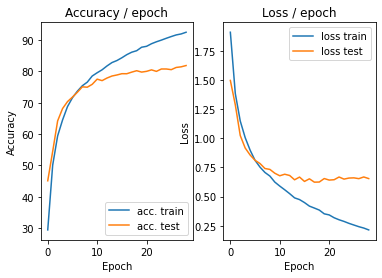

=== EPOCH 30 =====

[TRAIN Batch 000/100]	Time 0.530s (0.530s)	Loss 0.1612 (0.1612)	Prec@1  94.6 ( 94.6)	Prec@5  99.8 ( 99.8)


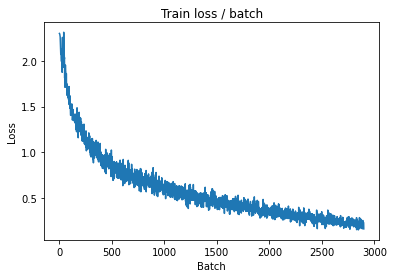


===============> Total time 19s	Avg loss 0.1993	Avg Prec@1 93.00 %	Avg Prec@5 99.92 %

[EVAL Batch 000/020]	Time 0.474s (0.474s)	Loss 0.7885 (0.7885)	Prec@1  79.8 ( 79.8)	Prec@5  98.2 ( 98.2)

===============> Total time 3s	Avg loss 0.6860	Avg Prec@1 81.68 %	Avg Prec@5 98.59 %



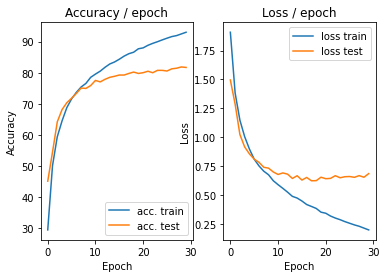

In [ ]:
main(500, 0.1, epochs= 30,cuda=True)

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode =True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(p=0.5)
  
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201]),
            transforms.CenterCrop(28)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()
        

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        lr_sched.step()
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/100]	Time 0.517s (0.517s)	Loss 2.3022 (2.3022)	Prec@1   9.8 (  9.8)	Prec@5  51.2 ( 51.2)


<Figure size 432x288 with 0 Axes>

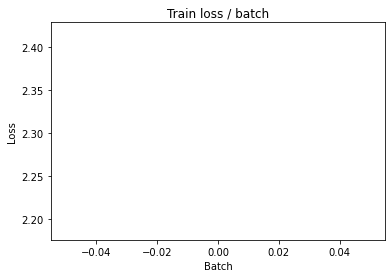


===============> Total time 19s	Avg loss 1.9371	Avg Prec@1 28.63 %	Avg Prec@5 79.08 %

[EVAL Batch 000/020]	Time 0.437s (0.437s)	Loss 1.7033 (1.7033)	Prec@1  37.2 ( 37.2)	Prec@5  88.8 ( 88.8)

===============> Total time 3s	Avg loss 1.6816	Avg Prec@1 38.21 %	Avg Prec@5 88.98 %



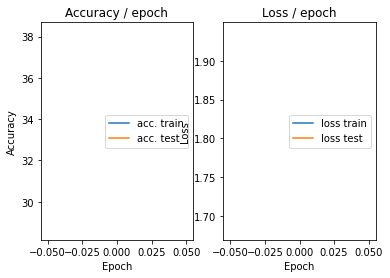

=== EPOCH 2 =====

[TRAIN Batch 000/100]	Time 0.508s (0.508s)	Loss 1.7986 (1.7986)	Prec@1  33.0 ( 33.0)	Prec@5  87.6 ( 87.6)


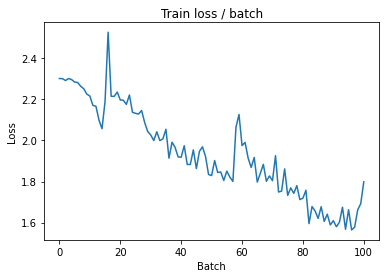


===============> Total time 19s	Avg loss 1.4563	Avg Prec@1 47.26 %	Avg Prec@5 92.28 %

[EVAL Batch 000/020]	Time 0.460s (0.460s)	Loss 1.2467 (1.2467)	Prec@1  54.6 ( 54.6)	Prec@5  95.4 ( 95.4)

===============> Total time 3s	Avg loss 1.2375	Avg Prec@1 56.10 %	Avg Prec@5 94.39 %



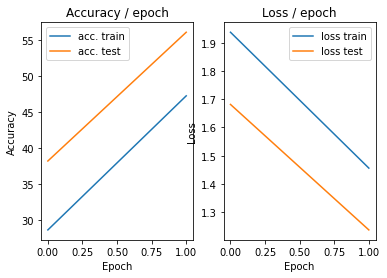

=== EPOCH 3 =====

[TRAIN Batch 000/100]	Time 0.504s (0.504s)	Loss 1.2927 (1.2927)	Prec@1  55.0 ( 55.0)	Prec@5  95.0 ( 95.0)


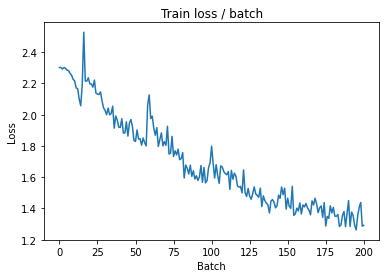


===============> Total time 19s	Avg loss 1.2261	Avg Prec@1 56.86 %	Avg Prec@5 94.69 %

[EVAL Batch 000/020]	Time 0.432s (0.432s)	Loss 1.0539 (1.0539)	Prec@1  60.8 ( 60.8)	Prec@5  97.0 ( 97.0)

===============> Total time 3s	Avg loss 1.0378	Avg Prec@1 63.02 %	Avg Prec@5 96.33 %



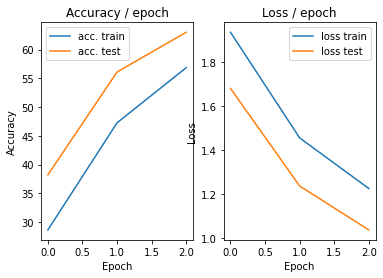

=== EPOCH 4 =====

[TRAIN Batch 000/100]	Time 0.724s (0.724s)	Loss 1.0395 (1.0395)	Prec@1  62.6 ( 62.6)	Prec@5  96.8 ( 96.8)


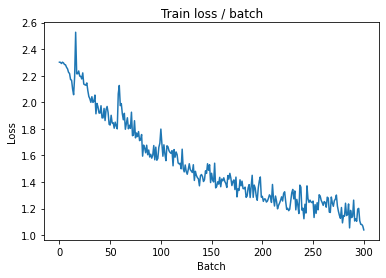


===============> Total time 19s	Avg loss 1.0938	Avg Prec@1 61.81 %	Avg Prec@5 96.01 %

[EVAL Batch 000/020]	Time 0.427s (0.427s)	Loss 1.0836 (1.0836)	Prec@1  63.0 ( 63.0)	Prec@5  96.0 ( 96.0)

===============> Total time 3s	Avg loss 1.0447	Avg Prec@1 64.64 %	Avg Prec@5 96.18 %



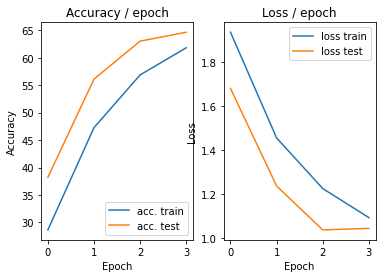

=== EPOCH 5 =====

[TRAIN Batch 000/100]	Time 0.542s (0.542s)	Loss 0.9781 (0.9781)	Prec@1  66.6 ( 66.6)	Prec@5  98.4 ( 98.4)


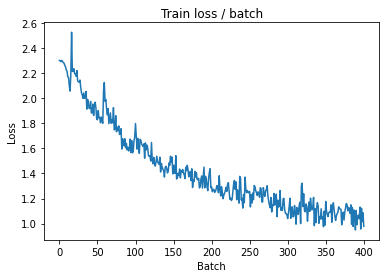


===============> Total time 19s	Avg loss 0.9849	Avg Prec@1 65.66 %	Avg Prec@5 96.75 %

[EVAL Batch 000/020]	Time 0.449s (0.449s)	Loss 0.8617 (0.8617)	Prec@1  68.4 ( 68.4)	Prec@5  97.6 ( 97.6)

===============> Total time 3s	Avg loss 0.9070	Avg Prec@1 68.89 %	Avg Prec@5 97.34 %



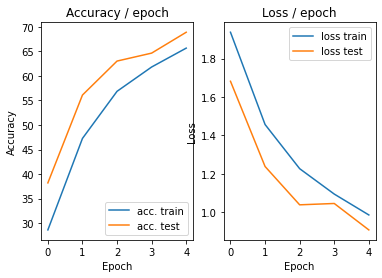

=== EPOCH 6 =====

[TRAIN Batch 000/100]	Time 0.534s (0.534s)	Loss 0.9378 (0.9378)	Prec@1  68.4 ( 68.4)	Prec@5  97.8 ( 97.8)


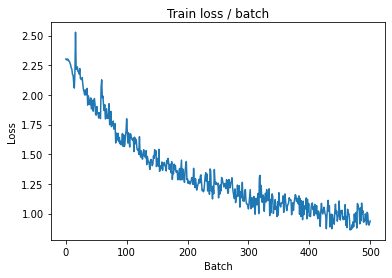


===============> Total time 19s	Avg loss 0.9148	Avg Prec@1 68.21 %	Avg Prec@5 97.13 %

[EVAL Batch 000/020]	Time 0.421s (0.421s)	Loss 0.8359 (0.8359)	Prec@1  68.4 ( 68.4)	Prec@5  97.8 ( 97.8)

===============> Total time 3s	Avg loss 0.8455	Avg Prec@1 71.14 %	Avg Prec@5 97.51 %



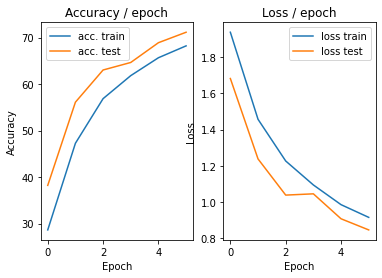

=== EPOCH 7 =====

[TRAIN Batch 000/100]	Time 0.535s (0.535s)	Loss 0.9107 (0.9107)	Prec@1  67.2 ( 67.2)	Prec@5  97.0 ( 97.0)


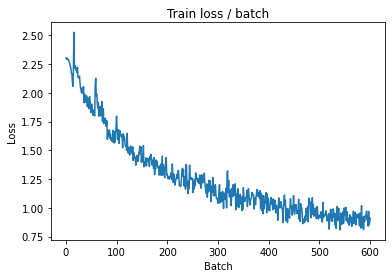


===============> Total time 19s	Avg loss 0.8696	Avg Prec@1 69.99 %	Avg Prec@5 97.45 %

[EVAL Batch 000/020]	Time 0.434s (0.434s)	Loss 0.8587 (0.8587)	Prec@1  70.2 ( 70.2)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.8384	Avg Prec@1 71.48 %	Avg Prec@5 97.69 %



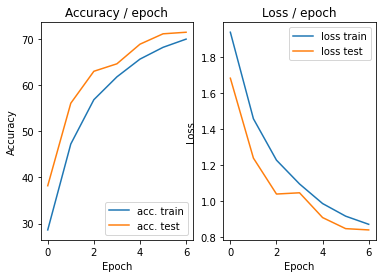

=== EPOCH 8 =====

[TRAIN Batch 000/100]	Time 0.540s (0.540s)	Loss 0.7869 (0.7869)	Prec@1  72.2 ( 72.2)	Prec@5  98.0 ( 98.0)


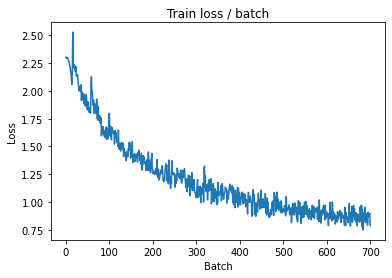


===============> Total time 19s	Avg loss 0.8097	Avg Prec@1 72.11 %	Avg Prec@5 97.73 %

[EVAL Batch 000/020]	Time 0.422s (0.422s)	Loss 0.7337 (0.7337)	Prec@1  73.8 ( 73.8)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.7490	Avg Prec@1 74.46 %	Avg Prec@5 97.95 %



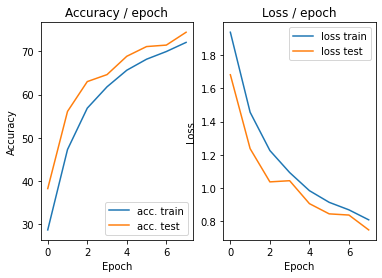

=== EPOCH 9 =====

[TRAIN Batch 000/100]	Time 0.724s (0.724s)	Loss 0.6865 (0.6865)	Prec@1  77.0 ( 77.0)	Prec@5  98.4 ( 98.4)


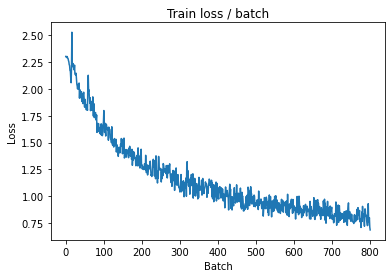


===============> Total time 19s	Avg loss 0.7833	Avg Prec@1 73.14 %	Avg Prec@5 97.85 %

[EVAL Batch 000/020]	Time 0.438s (0.438s)	Loss 0.7679 (0.7679)	Prec@1  72.4 ( 72.4)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.7869	Avg Prec@1 73.53 %	Avg Prec@5 97.79 %



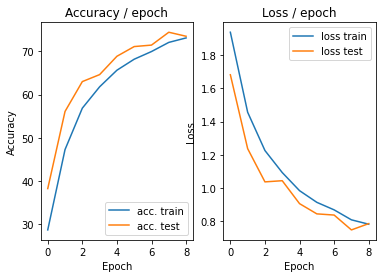

=== EPOCH 10 =====

[TRAIN Batch 000/100]	Time 0.535s (0.535s)	Loss 0.8217 (0.8217)	Prec@1  68.4 ( 68.4)	Prec@5  98.4 ( 98.4)


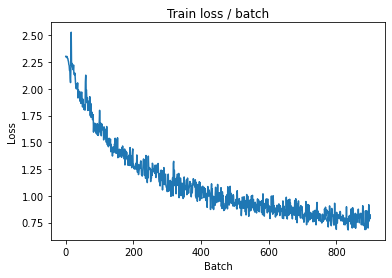


===============> Total time 19s	Avg loss 0.7521	Avg Prec@1 73.94 %	Avg Prec@5 98.02 %

[EVAL Batch 000/020]	Time 0.414s (0.414s)	Loss 0.7496 (0.7496)	Prec@1  73.8 ( 73.8)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.7501	Avg Prec@1 74.68 %	Avg Prec@5 97.88 %



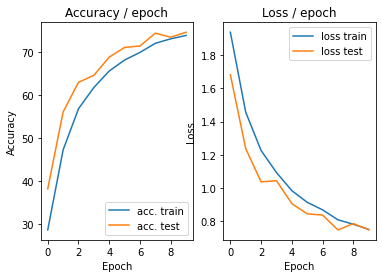

=== EPOCH 11 =====

[TRAIN Batch 000/100]	Time 0.555s (0.555s)	Loss 0.7558 (0.7558)	Prec@1  76.2 ( 76.2)	Prec@5  98.2 ( 98.2)


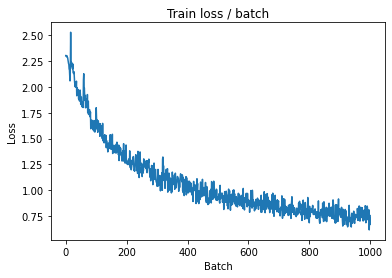


===============> Total time 19s	Avg loss 0.7264	Avg Prec@1 75.23 %	Avg Prec@5 98.18 %

[EVAL Batch 000/020]	Time 0.425s (0.425s)	Loss 0.7091 (0.7091)	Prec@1  75.2 ( 75.2)	Prec@5  98.6 ( 98.6)

===============> Total time 3s	Avg loss 0.6819	Avg Prec@1 76.95 %	Avg Prec@5 98.40 %



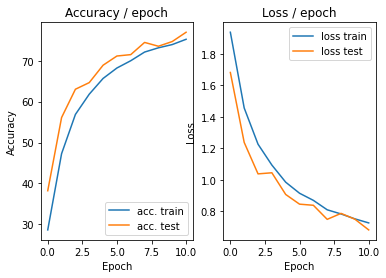

=== EPOCH 12 =====

[TRAIN Batch 000/100]	Time 0.562s (0.562s)	Loss 0.6977 (0.6977)	Prec@1  76.0 ( 76.0)	Prec@5  99.0 ( 99.0)


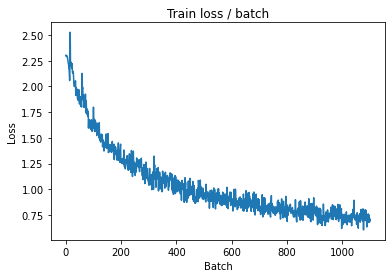


===============> Total time 19s	Avg loss 0.6944	Avg Prec@1 76.13 %	Avg Prec@5 98.31 %

[EVAL Batch 000/020]	Time 0.430s (0.430s)	Loss 0.6589 (0.6589)	Prec@1  77.4 ( 77.4)	Prec@5  99.6 ( 99.6)

===============> Total time 3s	Avg loss 0.6866	Avg Prec@1 77.03 %	Avg Prec@5 98.35 %



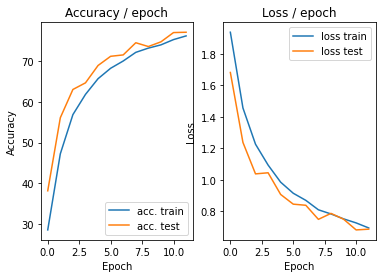

=== EPOCH 13 =====

[TRAIN Batch 000/100]	Time 0.534s (0.534s)	Loss 0.6631 (0.6631)	Prec@1  77.6 ( 77.6)	Prec@5  98.6 ( 98.6)


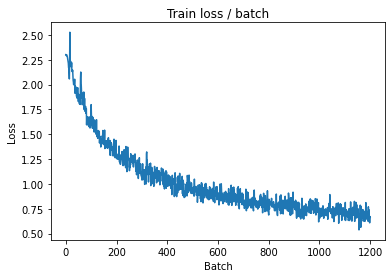


===============> Total time 19s	Avg loss 0.6611	Avg Prec@1 77.20 %	Avg Prec@5 98.51 %

[EVAL Batch 000/020]	Time 0.413s (0.413s)	Loss 0.6764 (0.6764)	Prec@1  78.6 ( 78.6)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.6656	Avg Prec@1 77.41 %	Avg Prec@5 98.49 %



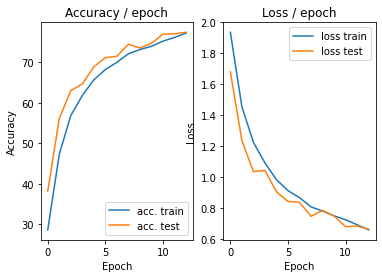

=== EPOCH 14 =====

[TRAIN Batch 000/100]	Time 0.528s (0.528s)	Loss 0.5807 (0.5807)	Prec@1  79.4 ( 79.4)	Prec@5  99.0 ( 99.0)


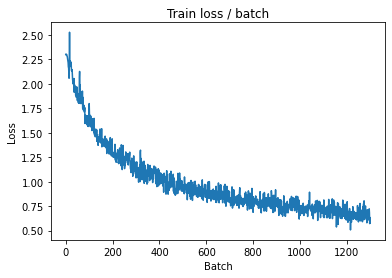


===============> Total time 19s	Avg loss 0.6365	Avg Prec@1 77.93 %	Avg Prec@5 98.61 %

[EVAL Batch 000/020]	Time 0.658s (0.658s)	Loss 0.6498 (0.6498)	Prec@1  78.6 ( 78.6)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.6651	Avg Prec@1 77.69 %	Avg Prec@5 98.50 %



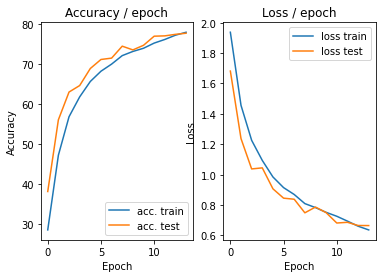

=== EPOCH 15 =====

[TRAIN Batch 000/100]	Time 0.516s (0.516s)	Loss 0.6561 (0.6561)	Prec@1  76.6 ( 76.6)	Prec@5  99.0 ( 99.0)


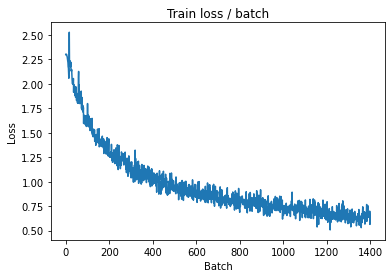


===============> Total time 19s	Avg loss 0.6182	Avg Prec@1 78.66 %	Avg Prec@5 98.71 %

[EVAL Batch 000/020]	Time 0.428s (0.428s)	Loss 0.6209 (0.6209)	Prec@1  79.4 ( 79.4)	Prec@5  99.4 ( 99.4)

===============> Total time 3s	Avg loss 0.6478	Avg Prec@1 78.50 %	Avg Prec@5 98.61 %



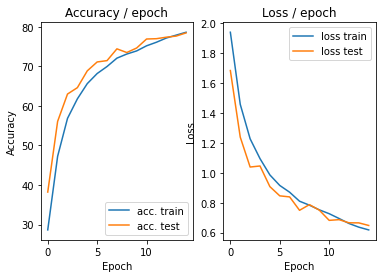

=== EPOCH 16 =====

[TRAIN Batch 000/100]	Time 0.546s (0.546s)	Loss 0.5423 (0.5423)	Prec@1  82.2 ( 82.2)	Prec@5  99.2 ( 99.2)


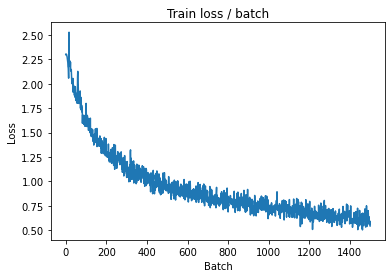


===============> Total time 19s	Avg loss 0.6107	Avg Prec@1 78.83 %	Avg Prec@5 98.74 %

[EVAL Batch 000/020]	Time 0.413s (0.413s)	Loss 0.6046 (0.6046)	Prec@1  78.6 ( 78.6)	Prec@5  98.8 ( 98.8)

===============> Total time 3s	Avg loss 0.6281	Avg Prec@1 78.97 %	Avg Prec@5 98.80 %



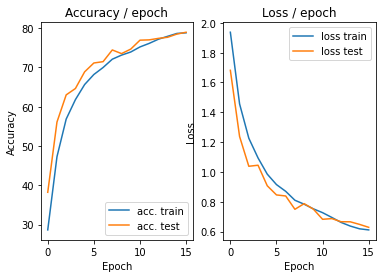

=== EPOCH 17 =====

[TRAIN Batch 000/100]	Time 0.543s (0.543s)	Loss 0.5241 (0.5241)	Prec@1  82.2 ( 82.2)	Prec@5  99.4 ( 99.4)


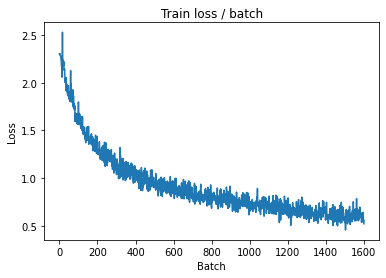


===============> Total time 19s	Avg loss 0.5779	Avg Prec@1 80.25 %	Avg Prec@5 98.82 %

[EVAL Batch 000/020]	Time 0.460s (0.460s)	Loss 0.6051 (0.6051)	Prec@1  80.2 ( 80.2)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.6213	Avg Prec@1 79.09 %	Avg Prec@5 98.67 %



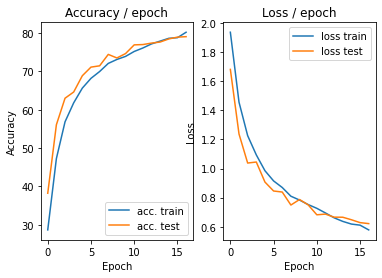

=== EPOCH 18 =====

[TRAIN Batch 000/100]	Time 0.494s (0.494s)	Loss 0.6650 (0.6650)	Prec@1  78.8 ( 78.8)	Prec@5  99.0 ( 99.0)


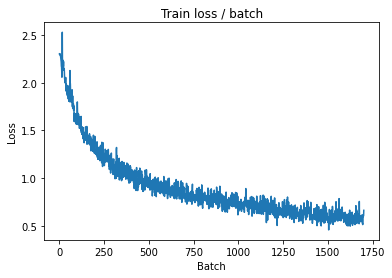


===============> Total time 19s	Avg loss 0.5657	Avg Prec@1 80.36 %	Avg Prec@5 98.94 %

[EVAL Batch 000/020]	Time 0.464s (0.464s)	Loss 0.6330 (0.6330)	Prec@1  80.2 ( 80.2)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.6147	Avg Prec@1 79.48 %	Avg Prec@5 98.85 %



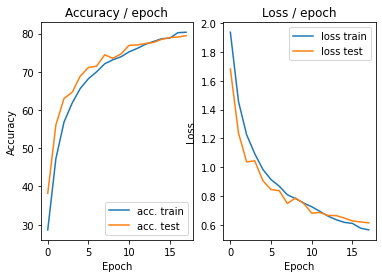

=== EPOCH 19 =====

[TRAIN Batch 000/100]	Time 0.557s (0.557s)	Loss 0.5855 (0.5855)	Prec@1  79.4 ( 79.4)	Prec@5  97.8 ( 97.8)


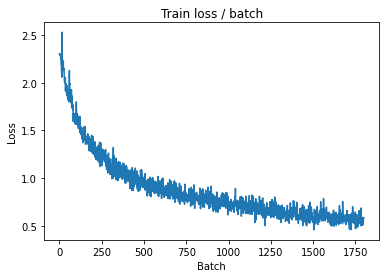


===============> Total time 19s	Avg loss 0.5488	Avg Prec@1 81.00 %	Avg Prec@5 99.03 %

[EVAL Batch 000/020]	Time 0.442s (0.442s)	Loss 0.6047 (0.6047)	Prec@1  79.6 ( 79.6)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.6177	Avg Prec@1 79.40 %	Avg Prec@5 98.61 %



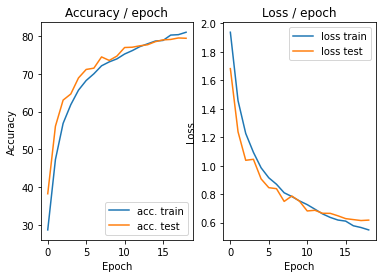

=== EPOCH 20 =====

[TRAIN Batch 000/100]	Time 0.728s (0.728s)	Loss 0.5434 (0.5434)	Prec@1  82.4 ( 82.4)	Prec@5  98.4 ( 98.4)


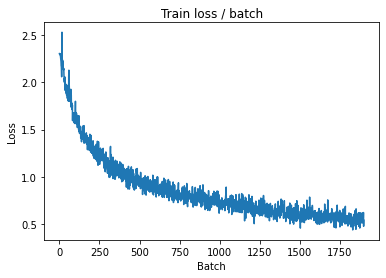


===============> Total time 19s	Avg loss 0.5352	Avg Prec@1 81.22 %	Avg Prec@5 99.07 %

[EVAL Batch 000/020]	Time 0.437s (0.437s)	Loss 0.5883 (0.5883)	Prec@1  80.2 ( 80.2)	Prec@5  99.6 ( 99.6)

===============> Total time 3s	Avg loss 0.6081	Avg Prec@1 79.51 %	Avg Prec@5 98.69 %



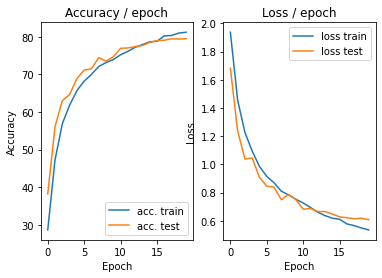

=== EPOCH 21 =====

[TRAIN Batch 000/100]	Time 0.513s (0.513s)	Loss 0.5099 (0.5099)	Prec@1  83.8 ( 83.8)	Prec@5  99.4 ( 99.4)


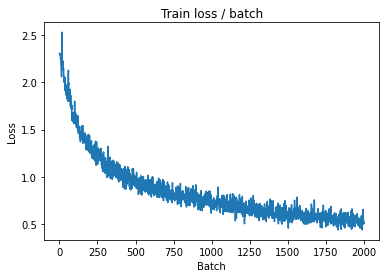


===============> Total time 19s	Avg loss 0.5173	Avg Prec@1 82.05 %	Avg Prec@5 99.14 %

[EVAL Batch 000/020]	Time 0.443s (0.443s)	Loss 0.5905 (0.5905)	Prec@1  81.8 ( 81.8)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.5820	Avg Prec@1 80.54 %	Avg Prec@5 98.88 %



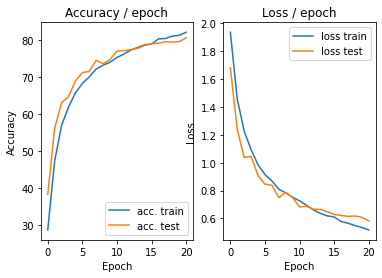

=== EPOCH 22 =====

[TRAIN Batch 000/100]	Time 0.534s (0.534s)	Loss 0.4390 (0.4390)	Prec@1  85.0 ( 85.0)	Prec@5  98.8 ( 98.8)


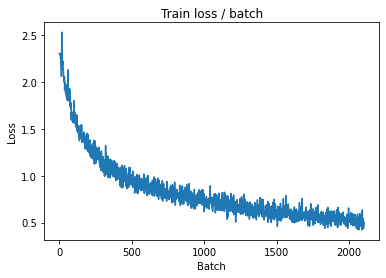


===============> Total time 19s	Avg loss 0.5063	Avg Prec@1 82.43 %	Avg Prec@5 99.11 %

[EVAL Batch 000/020]	Time 0.437s (0.437s)	Loss 0.5751 (0.5751)	Prec@1  81.0 ( 81.0)	Prec@5  99.4 ( 99.4)

===============> Total time 3s	Avg loss 0.5837	Avg Prec@1 80.53 %	Avg Prec@5 98.90 %



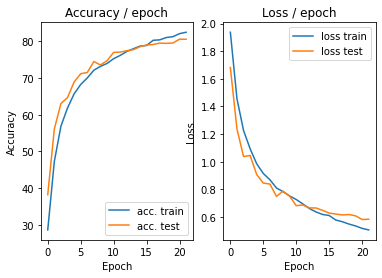

=== EPOCH 23 =====

[TRAIN Batch 000/100]	Time 0.549s (0.549s)	Loss 0.5655 (0.5655)	Prec@1  79.8 ( 79.8)	Prec@5  98.8 ( 98.8)


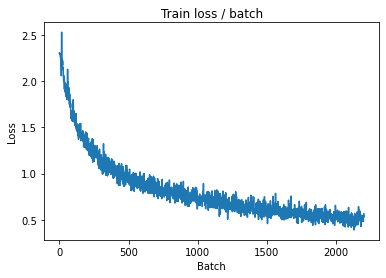


===============> Total time 19s	Avg loss 0.4941	Avg Prec@1 82.74 %	Avg Prec@5 99.26 %

[EVAL Batch 000/020]	Time 0.443s (0.443s)	Loss 0.5693 (0.5693)	Prec@1  81.4 ( 81.4)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.5691	Avg Prec@1 80.97 %	Avg Prec@5 98.90 %



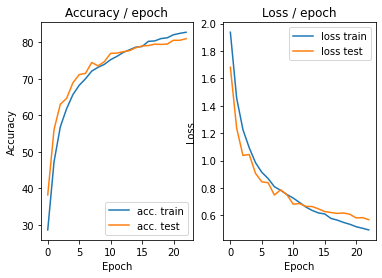

=== EPOCH 24 =====

[TRAIN Batch 000/100]	Time 0.573s (0.573s)	Loss 0.4019 (0.4019)	Prec@1  86.2 ( 86.2)	Prec@5  99.0 ( 99.0)


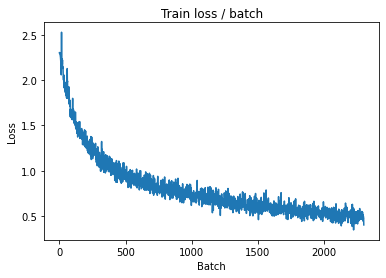


===============> Total time 19s	Avg loss 0.4835	Avg Prec@1 82.93 %	Avg Prec@5 99.26 %

[EVAL Batch 000/020]	Time 0.449s (0.449s)	Loss 0.4977 (0.4977)	Prec@1  82.0 ( 82.0)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.5692	Avg Prec@1 81.12 %	Avg Prec@5 98.87 %



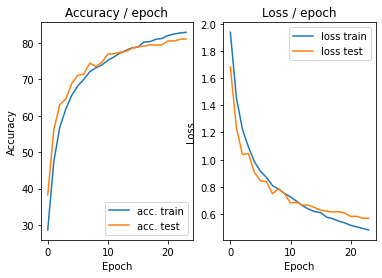

=== EPOCH 25 =====

[TRAIN Batch 000/100]	Time 0.523s (0.523s)	Loss 0.4536 (0.4536)	Prec@1  83.0 ( 83.0)	Prec@5  99.6 ( 99.6)


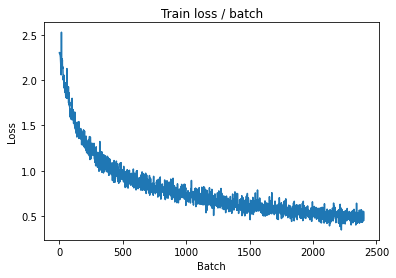


===============> Total time 19s	Avg loss 0.4674	Avg Prec@1 83.76 %	Avg Prec@5 99.30 %

[EVAL Batch 000/020]	Time 0.661s (0.661s)	Loss 0.5097 (0.5097)	Prec@1  82.8 ( 82.8)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.5582	Avg Prec@1 81.62 %	Avg Prec@5 98.70 %



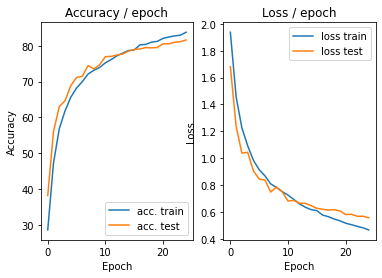

=== EPOCH 26 =====

[TRAIN Batch 000/100]	Time 0.525s (0.525s)	Loss 0.4652 (0.4652)	Prec@1  83.2 ( 83.2)	Prec@5  99.4 ( 99.4)


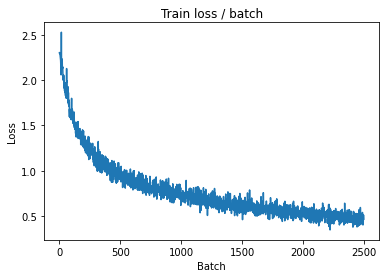


===============> Total time 19s	Avg loss 0.4532	Avg Prec@1 84.29 %	Avg Prec@5 99.36 %

[EVAL Batch 000/020]	Time 0.458s (0.458s)	Loss 0.5249 (0.5249)	Prec@1  81.6 ( 81.6)	Prec@5  99.4 ( 99.4)

===============> Total time 3s	Avg loss 0.5645	Avg Prec@1 81.16 %	Avg Prec@5 98.97 %



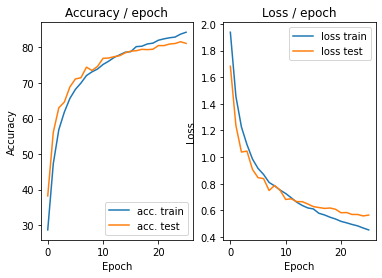

=== EPOCH 27 =====

[TRAIN Batch 000/100]	Time 0.547s (0.547s)	Loss 0.4539 (0.4539)	Prec@1  84.6 ( 84.6)	Prec@5  99.4 ( 99.4)


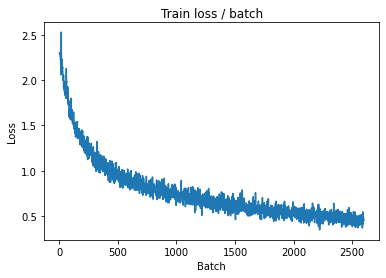


===============> Total time 19s	Avg loss 0.4481	Avg Prec@1 84.31 %	Avg Prec@5 99.37 %

[EVAL Batch 000/020]	Time 0.441s (0.441s)	Loss 0.5138 (0.5138)	Prec@1  81.8 ( 81.8)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.5592	Avg Prec@1 81.73 %	Avg Prec@5 98.89 %



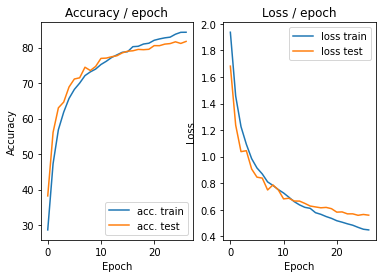

=== EPOCH 28 =====

[TRAIN Batch 000/100]	Time 0.536s (0.536s)	Loss 0.4066 (0.4066)	Prec@1  86.4 ( 86.4)	Prec@5  99.4 ( 99.4)


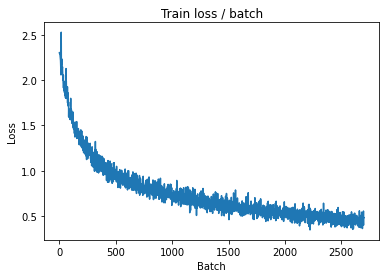


===============> Total time 19s	Avg loss 0.4329	Avg Prec@1 84.80 %	Avg Prec@5 99.41 %

[EVAL Batch 000/020]	Time 0.435s (0.435s)	Loss 0.5298 (0.5298)	Prec@1  82.4 ( 82.4)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.5621	Avg Prec@1 81.37 %	Avg Prec@5 98.84 %



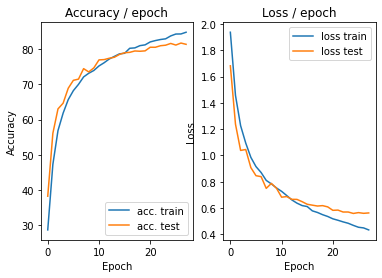

=== EPOCH 29 =====

[TRAIN Batch 000/100]	Time 0.535s (0.535s)	Loss 0.4271 (0.4271)	Prec@1  84.6 ( 84.6)	Prec@5  99.6 ( 99.6)


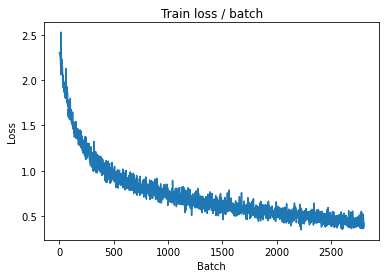


===============> Total time 19s	Avg loss 0.4271	Avg Prec@1 84.98 %	Avg Prec@5 99.42 %

[EVAL Batch 000/020]	Time 0.417s (0.417s)	Loss 0.5267 (0.5267)	Prec@1  83.4 ( 83.4)	Prec@5  99.0 ( 99.0)

===============> Total time 3s	Avg loss 0.5492	Avg Prec@1 82.27 %	Avg Prec@5 99.04 %



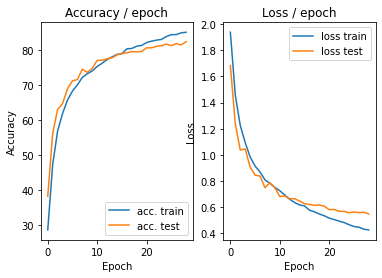

=== EPOCH 30 =====

[TRAIN Batch 000/100]	Time 0.511s (0.511s)	Loss 0.4197 (0.4197)	Prec@1  84.6 ( 84.6)	Prec@5  99.8 ( 99.8)


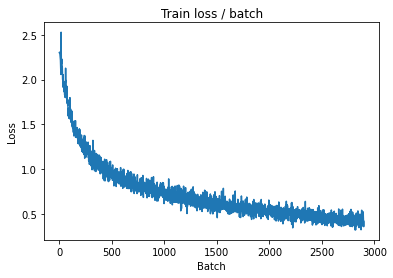


===============> Total time 19s	Avg loss 0.4167	Avg Prec@1 85.38 %	Avg Prec@5 99.46 %

[EVAL Batch 000/020]	Time 0.443s (0.443s)	Loss 0.4880 (0.4880)	Prec@1  83.8 ( 83.8)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.5365	Avg Prec@1 82.57 %	Avg Prec@5 98.99 %



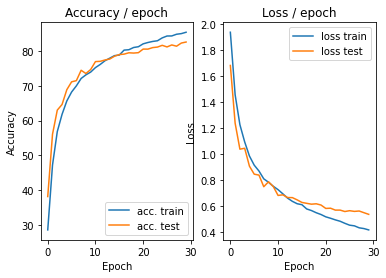

In [ ]:
main(500, 0.3, epochs= 30,cuda=True)

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode =True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(p=0.5)
  
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.491, 0.482, 0.447] , [0.202, 0.199, 0.201]),
            transforms.CenterCrop(28)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()
        

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        lr_sched.step()
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


In [ ]:
main(500, 0.1, epochs= 60,cuda=True)

Output hidden; open in https://colab.research.google.com to view.